# Redes neuronales convolucionales CNN's

In [1]:
!python --version

Python 3.10.17


## Importaciones necesarias

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
from tabulate import tabulate

from tqdm.auto import tqdm

from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn, SpinnerColumn
from rich.console import Console
from rich.live import Live
from rich.panel import Panel
from rich.table import Table

import seaborn as sns
from sklearn.metrics import confusion_matrix

## Configuración inicial: semilla y constantes

In [3]:
# Define la ruta donde guardaremos la base de datos
DATA_PATH = "./data/CIFAR/cifar-10-batches-py"
# Número de imágenes de entrenamiento
NUM_TRAIN = 45000
# Número de imágenes de validación
NUM_VAL = 5000
# Número de imágenes de test
NUM_TEST = 10000
# El tamaño de los minibatches
MINIBATCH_SIZE = 64
# Número de épocas para entrenamiento
EPOCHS = 50
# Paciencia para early stopping
PATIENCE = 3

# Configuración de semilla para reproducibilidad
def configurar_semilla(semilla=42):
    """Configurar semillas para reproducibilidad entre ejecuciones."""
    # Semilla para Python
    random.seed(semilla)
    # Semilla para NumPy
    np.random.seed(semilla)
    # Semilla para PyTorch (CPU y GPU)
    torch.manual_seed(semilla)

    # Para dispositivos CUDA (NVIDIA GPUs)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(semilla)
        torch.cuda.manual_seed_all(semilla)  # Para múltiples GPUs
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Para dispositivos MPS (Apple Silicon)
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        # Nota: torch.mps.manual_seed no existe aún, pero manual_seed
        # afecta también a MPS
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Semilla configurada a {semilla} para reproducibilidad")

configurar_semilla(42)

Semilla configurada a 42 para reproducibilidad


## Índice

1. [Técnicas de análisis y preprocesamiento de datos](#procesamiento)
  - 1.1 [Información general del dataset](#infodataset)
  - 1.2 [Análisis del balance de clases](#balance)
  - 1.3 [Visualización de muestras del dataset](#visualizacion)
  - 1.4 [Preprocesamiento y aumento de datos](#preprocesamiento)
    - 1.4.1 [Estrategia de aumento de datos](#da)
    - 1.4.2 [Normalización y transformación básica](#ntb)
    - 1.4.3 [Transformaciones específicas para modelos preentrenados](#tresnet)
    - 1.4.4 [División y configuración del conjunto de datos](#ds)
    - 1.4.5 [Ejemplo de aumento de datos](#daexample)
  - 1.5 [Verificación del preprocesamiento](#verificacion)
2. [Modelado](#modelado)
  - 2.0 [Utilidades para guardar y cargar los modelos](#save)
  - 2.1 [Usar GPU es más eficiente](#gpu)
  - 2.2 [Funciones de entrenamiento y exactitud del modelo](#acctrain)
  - 2.3 [Modelo 1: CNN de linea base](#cnnbase)
    - 2.3.1 [Arquitectura](#cnnbase-arq)
    - 2.3.2 [Entrenamiento](#cnnbase-ent)
    - 2.3.3 [Resultados](#cnnbase-res)
  - 2.4 [Modelo 2: Aprendizaje por transferencia](#transfer)
    - 2.4.1 [Configuración y adapatción del modelo](#transfer-conf)
    - 2.4.2 [Entrenamiento](#transfer-ent)
    - 2.4.3 [Resultados](#transfer-res)
  - 2.5 [Modelo 3: Ajuste fino del modelo de transfer learning](#fine)
    - 2.5.1 [Configuración y adapatción del modelo](#fine-conf)
    - 2.5.2 [Entrenamiento](#fine-ent)
    - 2.5.3 [Resultados](#fine-res)
  - 2.6 [Comparativa de resultados](#comparativa)
    - 2.6.1 [Análisis de exactitud](#analisis-exactitud)
    - 2.6.2 [Análisis de eficiencia computacional](#analisis-eficiencia)
    - 2.6.3 [Análisis de las matrices de confusión](#"analisis-confusion)
3. [Explicabilidad](#explicabilidad)
  - 3.1 [Análisis de mapas de activación GradCAM](#analisis_explicabilidad)
  - 3.2 [Interpretación de los resultados](#interpretacion_explicabilidad)
  - 3.3 [Conclusiones del análisis de explicabilidad](#conclusiones_explicabilidad)

## 1. Técnicas de análisis y preprocesamiento de datos<a name="procesamiento"></a>




### 1.1 Información General del dataset<a name="infodataset"></a>


El dataset CIFAR-10 constituye un referente estándar en el campo de la visión artificial. Se compone de 60.000 imágenes a color de baja resolución (32×32 píxeles) divididas equitativamente en 10 clases diferentes. Este conjunto de datos tiene unas características que favorecen el estudio y evaluación de algoritmos de clasificación de imágenes, al estar perfectamente balanceado y bien documentado.

### 1.2 Análisis del balance de clases<a name="balance"></a>

Files already downloaded and verified
Información General del Dataset CIFAR-10:


,Métrica,Valor
0,Número total de imágenes,50000
1,Número de clases,10
2,Imágenes por clase,5000
3,Dimensiones de imagen,32x32x3
4,Conjunto de entrenamiento,"45,000"
5,Conjunto de validación,"5,000"
6,Conjunto de test,"10,000"



Distribución detallada por clases:


,Clase,Número de imágenes,Porcentaje
0,airplane,"5,000",10.00%
1,automobile,"5,000",10.00%
2,bird,"5,000",10.00%
3,cat,"5,000",10.00%
4,deer,"5,000",10.00%
5,dog,"5,000",10.00%
6,frog,"5,000",10.00%
7,horse,"5,000",10.00%
8,ship,"5,000",10.00%
9,truck,"5,000",10.00%


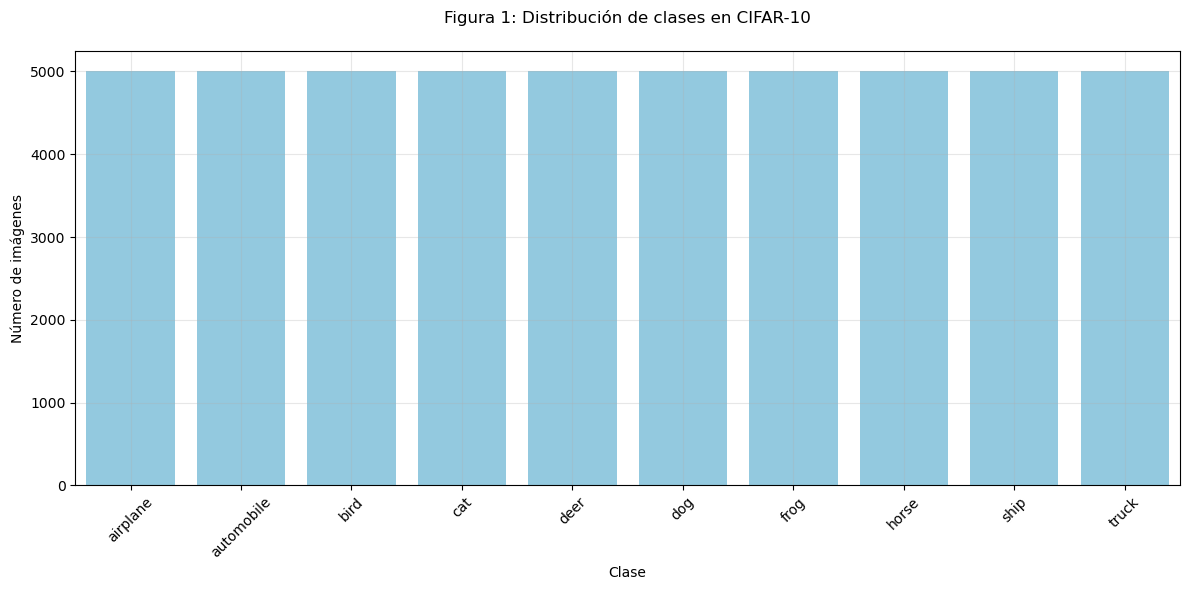

In [4]:
# Cargamos el dataset raw para análisis
cifar10_raw = datasets.CIFAR10(DATA_PATH, train=True, download=True, transform=None)
all_labels = cifar10_raw.targets
unique_labels, counts = np.unique(all_labels, return_counts=True)

# Crear DataFrame con información general
df_general = pd.DataFrame({
    'Métrica': ['Número total de imágenes',
                'Número de clases',
                'Imágenes por clase',
                'Dimensiones de imagen',
                'Conjunto de entrenamiento',
                'Conjunto de validación',
                'Conjunto de test'],
    'Valor': [len(cifar10_raw),
              len(cifar10_raw.classes),
              len(cifar10_raw)//len(cifar10_raw.classes),
              '32x32x3',
              f'{NUM_TRAIN:,}',
              f'{NUM_VAL:,}',
              f'{NUM_TEST:,}'
    ]
}, index=None)

# Mostrar información general
print("Información General del Dataset CIFAR-10:")
display(df_general.style
        .set_caption("Tabla 1: Características generales del dataset CIFAR-10")
        .set_properties(**{'text-align': 'left'}))

# Crear DataFrame con la información de las clases
df_classes = pd.DataFrame({
    'Clase': cifar10_raw.classes,
    'Número de imágenes': counts,
    'Porcentaje': (counts/len(all_labels)*100).round(2)
})

# Mostrar tabla con estilo
print("\nDistribución detallada por clases:")
display(df_classes.style
        .set_caption("Tabla 2: Distribución de clases en CIFAR-10")
        .format({'Número de imágenes': '{:,}',
                'Porcentaje': '{:.2f}%'})
        .background_gradient(subset=['Número de imágenes'], cmap='Blues')
        .background_gradient(subset=['Porcentaje'], cmap='Blues'))

# Visualización con seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_classes, x='Clase', y='Número de imágenes', color='skyblue')
plt.title('Figura 1: Distribución de clases en CIFAR-10', pad=20)
plt.xticks(rotation=45)
plt.ylabel('Número de imágenes')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Nuestro análisis inicial confirma el equilibrio perfecto del dataset CIFAR-10. Como podemos observar en los datos, cada una de las 10 clases (avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión) cuenta con exactamente 5.000 imágenes en el conjunto de entrenamiento, lo que representa un 10% del total. Esta distribución uniforme es ideal para el entrenamiento de modelos de clasificación, ya que evita problemas de sesgo hacia clases mayoritarias que podrían comprometer el aprendizaje.

La **tabla 1** presenta las características generales del dataset CIFAR-10, incluyendo el número total de imágenes (50.000 en el conjunto de entrenamiento) y la distribución por subconjuntos (45.000 para entrenamiento, 5.000 para validación y 10.000 para prueba). La **tabla 2** muestra la distribución detallada por clases, confirmando el equilibrio con 5.000 imágenes y un 10% exacto para cada categoría.

La **figura 1** ofrece una representación gráfica de este balance mediante un diagrama de barras, donde podemos visualizar la distribución equitativa entre las diferentes categorías.

### 1.3 Visualización de muestras del dataset<a name="visualizacion"></a>

Para comprender mejor la naturaleza de las imágenes con las que trabajaremos, hemos realizado una exploración visual del dataset CIFAR-10. La **figura 2** muestra una selección aleatoria de ejemplos de diferentes clases, donde podemos apreciar la diversidad de objetos incluidos en cada categoría.
A pesar de su baja resolución (32×32×3), estas imágenes contienen suficiente información para distinguir las diferentes categorías, aunque presentan variaciones considerables en los ángulos de captura, condiciones de iluminación y posiciones de los objetos. Esta variabilidad natural es una gran ventaja de cara al entrenamiento, ya que enriquece la capacidad de generalización de los modelos.

Muestras aleatorias del dataset:


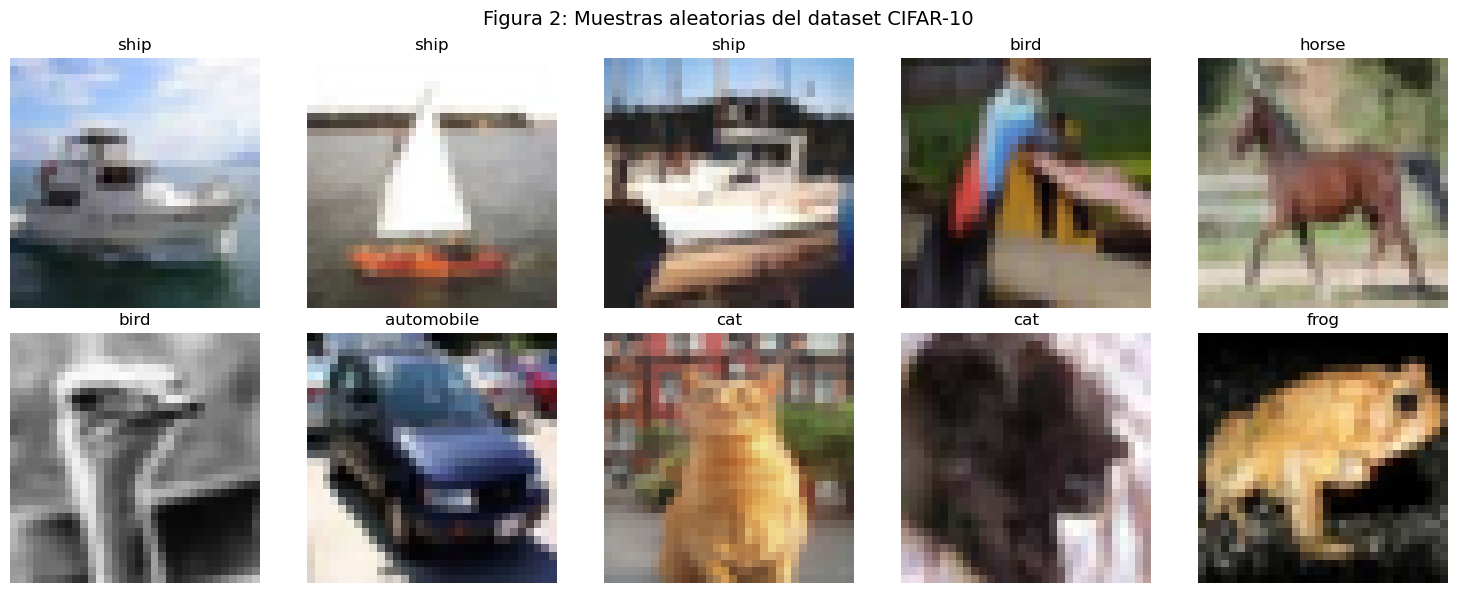

In [5]:
def show_random_images(dataset, num_images=10):
    """Muestra imágenes aleatorias del dataset."""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for idx in range(num_images):
        img, label = dataset[np.random.randint(len(dataset))]
        axes[idx].imshow(img)
        axes[idx].set_title(dataset.classes[label])
        axes[idx].axis('off')

    plt.suptitle('Figura 2: Muestras aleatorias del dataset CIFAR-10', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Ajusta el espacio superior para el título
    plt.show()

print("Muestras aleatorias del dataset:")
show_random_images(cifar10_raw)

Files already downloaded and verified


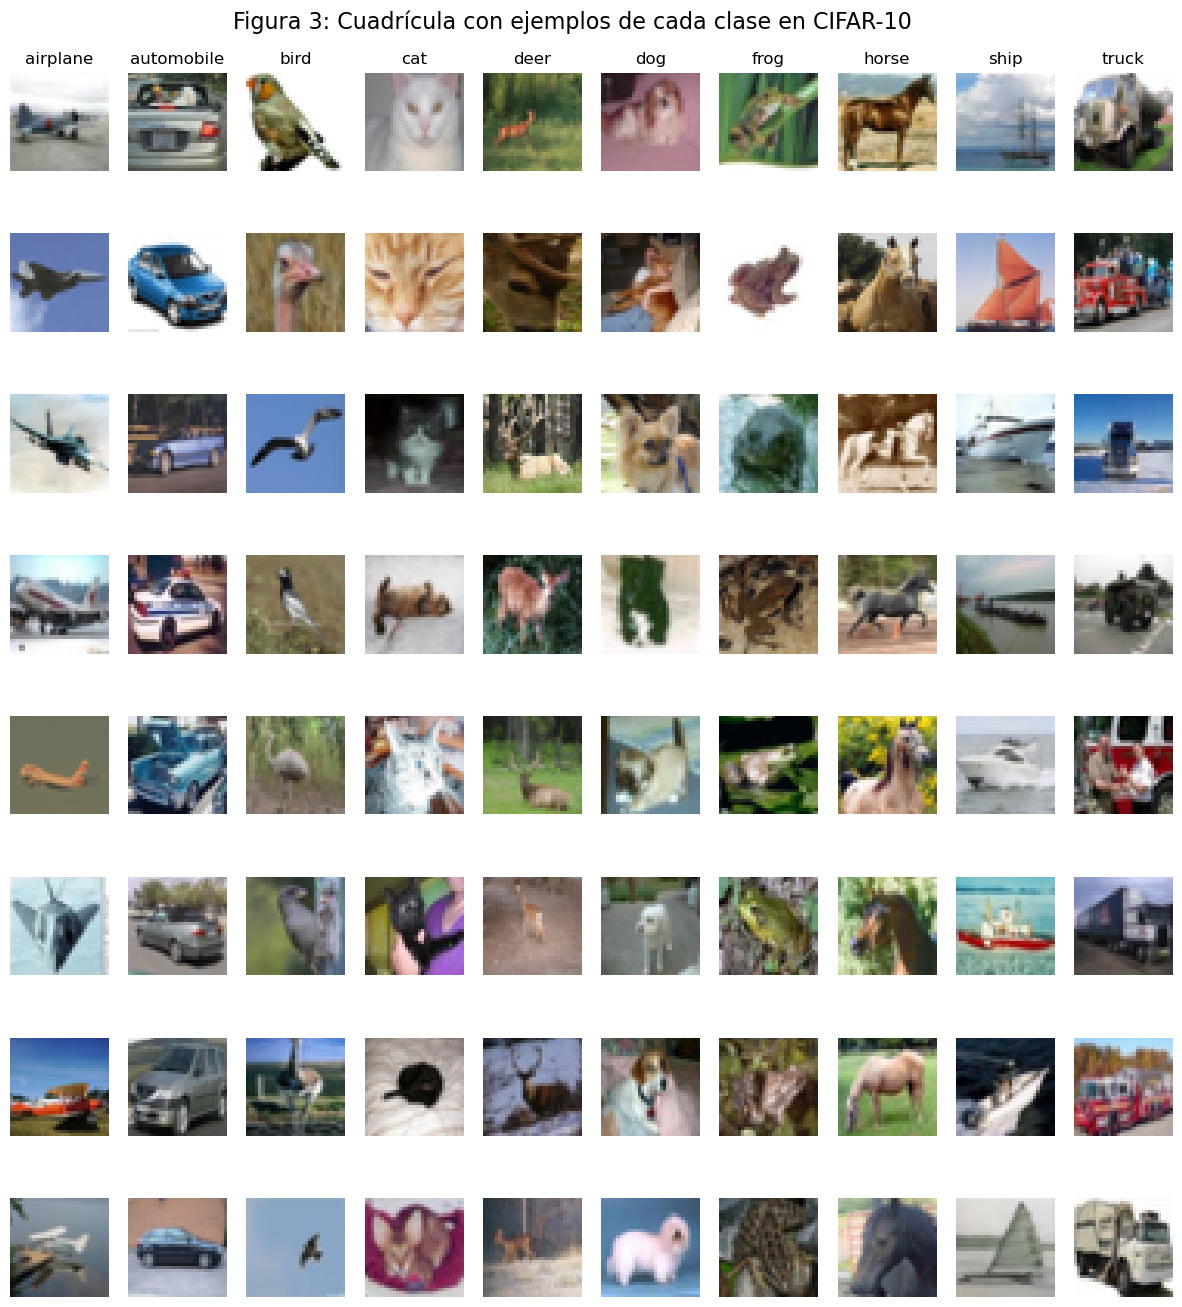

In [6]:
# Función para mostrar grid con las imágenes
def plot_cifar10_grid():
    """Muestra una cuadrícula con múltiples ejemplos de cada clase."""
    # Obtiene la lista de clases
    test_loader = DataLoader(datasets.CIFAR10(DATA_PATH, train=False, download=True), batch_size=1)
    classes = test_loader.dataset.classes
    # Define el total de filas por clase
    total_samples = 8
    # Define el tamaño de la figura (del grid completo)
    plt.figure(figsize=(15,15))
    # Por cada etiqueta de clase
    for label, sample in enumerate(classes):
        # Devuelve los índices de las imágenes que pertenecen a la clase actual
        # Primero convierte la lista de etiquetas en un array numpy
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        # Obtiene exactamente 8 muestras de la clase actual tomadas
        # aleatoriamente y sin repetición
        sample_idxs = np.random.choice(class_idxs, total_samples, replace=False)
        # Genera una columna de 8 muestras aleatorias de cada clase
        for i, idx in enumerate(sample_idxs):
            # Lugar que ocupará la imagen en el grid
            # Por ejemplo para la clase 0 (1, 11, 21, 31, 41...)
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            # Imprime el título si es la primera imagen
            if i == 0: plt.title(sample)

    plt.suptitle('Figura 3: Cuadrícula con ejemplos de cada clase en CIFAR-10', fontsize=16)
    plt.subplots_adjust(top=0.95)  # Ajusta el espacio superior para el título
    plt.show()

plot_cifar10_grid()

La **figura 3** ofrece una visualización más estructurada, mostrando una cuadrícula con múltiples ejemplos de cada clase organizados en columnas. Este formato nos permite realizar comparaciones directas y apreciar tanto la variabilidad dentro de una misma categoría como los posibles parecidos entre categorías diferentes.
Por ejemplo, podemos observar cómo las clases perro y gato presentan algunas similitudes morfológicas que podrían complicar su distinción, especialmente en imágenes donde solo se muestra la cabeza. También, los camiones y los automóviles comparten características estructurales básicas que pueden suponer una dificultad añadida para su clasificación. Estas similitudes y diferencias nos servirán para interpretar mejor los resultados de los modelos y analizar posibles confusiones en la clasificación.

### 1.4 Preprocesamiento y aumento de datos<a name="preprocesamiento"></a>




#### 1.4.1 Estrategias de aumento de datos<a name="da"></a>

Aunque el conjunto CIFAR-10 presenta un balance perfecto con 6.000 imágenes por clase y un volumen considerable de 50.000 imágenes de entrenamiento, hemos incorporado técnicas de aumento de datos para potenciar el aprendizaje de nuestros modelos basándonos en que:
- Mejora la generalización del modelo, reduciendo el sobreajuste.
- Al aplicarse "al vuelo" durante el entrenamiento, proporciona mayor variabilidad sin duplicar físicamente el dataset.
- Es una práctica estándar en visión artificial que ha demostrado mejorar el rendimiento, incluso en datasets bien balanceados.

Las transformaciones implementadas varían según la arquitectura:

**Para la CNN base:**

In [7]:
# Transformaciones para entrenamiento con data augmentation
# en el modelo cnn base
transform_train_augmented = T.Compose([
    T.RandomCrop(32, padding=4),       # Recorte aleatorio con padding
    T.RandomHorizontalFlip(p=0.5),     # Volteo horizontal con 50% de probabilidad
    T.RandomRotation(15),              # Rotación aleatoria de hasta 15 grados
    T.ToTensor(),                      # Conversión a tensor
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])  # Normalización
])

**Para modelos preentrenados (ResNet18):** basadas en <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html">Pytotrch docs</a>

In [8]:
# Transformaciones para entrenamiento con data augmentation
# en los modelor resnet18
transform_pretrained_train = T.Compose([
    T.Resize(256),                     # Redimensionamiento inicial
    T.RandomCrop(224, padding=4),      # Recorte aleatorio con padding
    T.RandomHorizontalFlip(p=0.2),     # Volteo horizontal con 20% de probabilidad
    T.RandomRotation(5),               # Rotación ligera (5 grados máximo)
    T.ToTensor(),                      # Conversión a tensor
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización ImageNet
])

#### 1.4.2 Normalización y transformación básica<a name="ntb"></a>

Todas nuestras implementaciones incluyen dos pasos fundamentales:

1. **Conversión a tensores** mediante ToTensor(), que normaliza los valores a [0,1] y reorganiza las dimensiones al formato requerido por PyTorch (C×H×W).
2. **Normalización estadística** adaptada a cada caso:

 - Para la CNN base utilizamos valores precomputados específicos para CIFAR-10:
    - Medias: [0.491, 0.482, 0.447]
    - Desviaciones estándar: [0.247, 0.243, 0.261]
  - Para los modelos preentrenados empleamos los valores estándar de ImageNet:
    - Medias: [0.485, 0.456, 0.406]
    - Desviaciones estándar: [0.229, 0.224, 0.225]

Esta normalización produce datos con media cercana a 0 y desviación estándar aproximada de 1, lo que favorece la convergencia durante el entrenamiento y reduce problemas de inestabilidad numérica.

In [9]:
# Transformaciones para CNN base
transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

#### 1.4.3 Transformaciones específicas para modelos preentrenados<a name="tresnet"></a>

Los modelos preentrenados en ImageNet requieren preparación adicional (<a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html">Pytotrch docs</a>):

In [10]:
# Transformaciones especídicas para los modelos preentrenados
transform_pretrained = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Este redimensionamiento es necesario debido a que:
- ResNet18 fue entrenado con imágenes de 224×224 píxeles.
- Las imágenes originales de CIFAR-10 (32×32) son demasiado pequeñas.
- Mantener las mismas dimensiones facilita la transferencia de características aprendidas en ImageNet.

#### 1.4.4 División y configuración del conjunto de datos<a name="ds"></a>

Para asegurar una evaluación correcta, hemos dividido el dataset CIFAR-10 en tres conjuntos:

- **Entrenamiento**: 45.000 imágenes (75% del total)
- **Validación**: 5.000 imágenes (8,3% del total)
- **Prueba**: 10.000 imágenes (16,7% del total)

Esta división se implementa mediante el uso de ```SubsetRandomSampler``` de PyTorch, que permite extraer subconjuntos específicos manteniendo la distribución original de clases. Para cada tipo de modelo (CNN base y modelos preentrenados), hemos preparado conjuntos con las transformaciones apropiadas:

In [11]:
# Para CNN base
# Train dataset con data augmentation
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_train_augmented)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation dataset
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

# Test dataset
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

# Para modelos preentrenados (ResNet18)
# Train dataset con data augmentation
cifar10_train_pretrained = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                     transform=transform_pretrained_train)
train_loader_pretrained = DataLoader(cifar10_train_pretrained, batch_size=MINIBATCH_SIZE,
                              sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation dataset
cifar10_val_pretrained = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                   transform=transform_pretrained)
val_loader_pretrained = DataLoader(cifar10_val_pretrained, batch_size=MINIBATCH_SIZE,
                            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

# Test dataset
cifar10_test_pretrained = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                                    transform=transform_pretrained)
test_loader_pretrained = DataLoader(cifar10_test_pretrained, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### 1.4.5 Ejemplo de aumento de datos<a name="daexample"></a>

Files already downloaded and verified


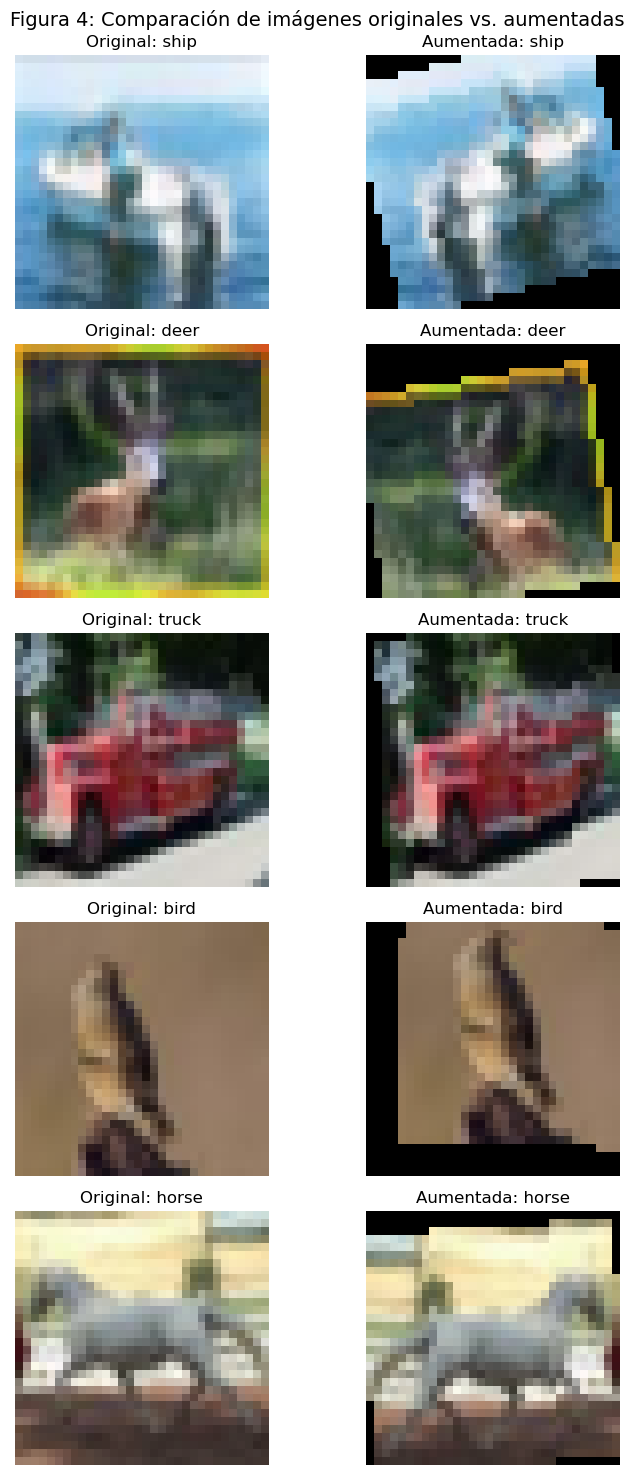

In [12]:
# Mostramos ejemplos de data augmentation
def show_augmented_samples(dataset, num_samples=5):
    """Muestra ejemplos originales y aumentados para comparación."""
    # Dataset original
    dataset_original = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                       transform=T.Compose([
                                           T.ToTensor(),
                                           T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
                                       ]))

    # Elegimos samples aleatorios
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 3*num_samples))

    for i, idx in enumerate(indices):
        # Imagen original
        img_orig, label = dataset_original[idx]
        img_orig = img_orig.permute(1, 2, 0).numpy()
        img_orig = (img_orig * np.array([0.247, 0.243, 0.261]) +
                   np.array([0.491, 0.482, 0.447])).clip(0, 1)

        # Imagen aumentada (necesitamos acceder a la imagen original y aplicar transformación)
        img_aug, _ = dataset[idx]
        img_aug = img_aug.permute(1, 2, 0).numpy()
        img_aug = (img_aug * np.array([0.247, 0.243, 0.261]) +
                  np.array([0.491, 0.482, 0.447])).clip(0, 1)

        axes[i, 0].imshow(img_orig)
        axes[i, 0].set_title(f'Original: {dataset.classes[label]}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img_aug)
        axes[i, 1].set_title(f'Aumentada: {dataset.classes[label]}')
        axes[i, 1].axis('off')

    plt.suptitle('Figura 4: Comparación de imágenes originales vs. aumentadas', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Mostrar ejemplos
show_augmented_samples(cifar10_train)

La **figura 4** muestra unos ejemplos de cómo se realizará el aumento de datos durante el entrenaminedo. Además en la celda siguiente organizamos todos los dataloaders en un diccionario para poder acceder más fácilmente durante los experimentos:

In [22]:
# Organizar dataloaders en un diccionario para fácil acceso
loaders = {
    'basic': {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    },
    'pretrained': {
        'train': train_loader_pretrained,
        'val': val_loader_pretrained,
        'test': test_loader_pretrained
    }
}

print(f"Dataloaders configurados:")
print(f"Train (CNN base): {len(train_loader.sampler)} imágenes")
print(f"Train (Pretrained): {len(train_loader_pretrained.sampler)} imágenes")
print(f"Validation: {len(val_loader.sampler)} imágenes")
print(f"Test: {len(test_loader.dataset)} imágenes")

Dataloaders configurados:
Train (CNN base): 45000 imágenes
Train (Pretrained): 45000 imágenes
Validation: 5000 imágenes
Test: 10000 imágenes


### 1.5 Verificación del preprocesamiento<a name="verificacion"></a>

Para confirmar que nuestras transformaciones se han aplicado correctamente, hemos realizado verificaciones estadísticas sobre los datos preprocesados. A continuación mostramos los resultados de estas comprobaciones, que nos permiten verificar que el preprocesamiento se ha aplicado correctamente.

In [23]:
def verify_preprocessing():
    """Verifica el preprocesamiento mostrando estadísticas de los datos transformados."""
    # Obtener un batch de datos
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch

    # Crear DataFrame con información general
    preprocessing_info = pd.DataFrame({
        'Métrica': [
            'Dimensiones del batch',
            'Rango mínimo de valores',
            'Rango máximo de valores',
            'Media',
            'Desviación estándar'
        ],
        'Valor': [
            str(tuple(images.shape)),
            f'{images.min():.3f}',
            f'{images.max():.3f}',
            f'{images.mean():.3f}',
            f'{images.std():.3f}'
        ]
    })

    # Crear DataFrame con estadísticas por canal
    channel_stats = pd.DataFrame({
        'Canal': ['Rojo', 'Verde', 'Azul'],
        'Media': [
            f'{images[:,0,:,:].mean():.3f}',
            f'{images[:,1,:,:].mean():.3f}',
            f'{images[:,2,:,:].mean():.3f}'
        ],
        'Desviación': [
            f'{images[:,0,:,:].std():.3f}',
            f'{images[:,1,:,:].std():.3f}',
            f'{images[:,2,:,:].std():.3f}'
        ]
    })

    print("\nEstadísticas generales del preprocesamiento para CNN base:")
    display(preprocessing_info.style
            .set_caption("Tabla 3: Estadísticas generales del preprocesamiento para CNN base")
            .set_properties(**{'text-align': 'left'}))

    print("\nEstadísticas por canal para CNN base:")
    display(channel_stats.style
            .set_caption("Tabla 4: Estadísticas por canal de color para CNN base")
            .set_properties(**{'text-align': 'left'})
            .background_gradient(subset=['Media', 'Desviación'], cmap='Blues'))

    # Verificación para modelos preentrenados
    sample_batch_pretrained = next(iter(train_loader_pretrained))
    images_pretrained, _ = sample_batch_pretrained

    # Crear DataFrame para modelos preentrenados
    preprocessing_info_pretrained = pd.DataFrame({
        'Métrica': [
            'Dimensiones del batch',
            'Rango mínimo de valores',
            'Rango máximo de valores',
            'Media',
            'Desviación estándar'
        ],
        'Valor': [
            str(tuple(images_pretrained.shape)),
            f'{images_pretrained.min():.3f}',
            f'{images_pretrained.max():.3f}',
            f'{images_pretrained.mean():.3f}',
            f'{images_pretrained.std():.3f}'
        ]
    })

    print("\nEstadísticas generales del preprocesamiento para modelos preentrenados:")
    display(preprocessing_info_pretrained.style
            .set_caption("Tabla 5: Estadísticas del preprocesamiento para modelos preentrenados")
            .set_properties(**{'text-align': 'left'}))

verify_preprocessing()


Estadísticas generales del preprocesamiento para CNN base:


,Métrica,Valor
0,Dimensiones del batch,"(64, 3, 32, 32)"
1,Rango mínimo de valores,-1.988
2,Rango máximo de valores,2.132
3,Media,-0.363
4,Desviación estándar,1.141



Estadísticas por canal para CNN base:


,Canal,Media,Desviación
0,Rojo,-0.379,1.169
1,Verde,-0.379,1.160
2,Azul,-0.331,1.093



Estadísticas generales del preprocesamiento para modelos preentrenados:


,Métrica,Valor
0,Dimensiones del batch,"(64, 3, 224, 224)"
1,Rango mínimo de valores,-2.118
2,Rango máximo de valores,2.640
3,Media,0.142
4,Desviación estándar,1.156


Como podemos observar en las **Tablas 3 y 4**, los datos para la CNN base han sido normalizados correctamente, con medias cercanas a cero y desviaciones estándar próximas a uno. De manera similar, la **Tabla 5** confirma que las transformaciones para los modelos preentrenados se han aplicado adecuadamente, con el redimensionamiento a 224×224 píxeles y la normalización correspondiente.

Además de verificar las estadísticas de los datos transformados, también es importante comprobar que la división del dataset en conjuntos de entrenamiento, validación y prueba mantiene una distribución equilibrada de las clases:

In [24]:
def verify_dataset_split():
    """Verifica la división del dataset y el balance de clases en cada conjunto."""
    # Crear DataFrame con la información de la división
    split_info = pd.DataFrame({
        'Conjunto': ['Entrenamiento', 'Validación', 'Test', 'Total'],
        'Número de imágenes': [
            NUM_TRAIN,
            NUM_VAL,
            NUM_TEST,
            NUM_TRAIN + NUM_VAL + NUM_TEST
        ],
        'Porcentaje': [
            f"{(NUM_TRAIN/(NUM_TRAIN + NUM_VAL + NUM_TEST))*100:.1f}%",
            f"{(NUM_VAL/(NUM_TRAIN + NUM_VAL + NUM_TEST))*100:.1f}%",
            f"{(NUM_TEST/(NUM_TRAIN + NUM_VAL + NUM_TEST))*100:.1f}%",
            "100%"
        ]
    })

    # Mostrar tabla con estilo
    display(split_info.style
            .set_caption("Tabla 6: División del dataset CIFAR-10")
            .format({'Número de imágenes': '{:,}'})
            .background_gradient(subset=['Número de imágenes'], cmap='Blues'))

    # Verificar balance de clases en cada conjunto
    def check_class_balance(loader, name):
        all_labels = []
        # Limitamos la iteración para evitar errores de índice
        try:
            for _, labels in loader:
                all_labels.extend(labels.cpu().numpy())
                # Limitar a un máximo de muestras representativas
                if len(all_labels) > 5000:
                    break
        except Exception as e:
            print(f"Advertencia: Error al procesar {name}: {e}")
            return pd.Series([0] * 10, index=cifar10_train.classes, name=name)

        if not all_labels:
            print(f"Advertencia: No se pudieron obtener etiquetas para {name}")
            return pd.Series([0] * 10, index=cifar10_train.classes, name=name)

        unique, counts = np.unique(all_labels, return_counts=True)
        # Asegurarse de que hay un valor para cada clase
        all_counts = np.zeros(10)
        for u, c in zip(unique, counts):
            if u < 10:  # Asegurarse de que el índice es válido
                all_counts[u] = c

        return pd.Series(all_counts, index=cifar10_train.classes, name=name)

    # Obtener distribución de clases para cada conjunto
    try:
        train_dist = check_class_balance(train_loader, 'Entrenamiento')
        val_dist = check_class_balance(val_loader, 'Validación')
        test_dist = check_class_balance(test_loader, 'Test')

        # Crear DataFrame con la distribución de clases
        class_distribution = pd.concat([train_dist, val_dist, test_dist], axis=1)

        print("\nDistribución de clases en cada conjunto:")
        display(class_distribution.style
                .set_caption("Tabla 7: Distribución de clases por conjunto")
                .background_gradient(cmap='Blues'))
    except Exception as e:
        print(f"Error al analizar la distribución de clases: {e}")
        print("Sugerencia: Verifica que los índices de los samplers no excedan el tamaño del dataset")

verify_dataset_split()

,Conjunto,Número de imágenes,Porcentaje
0,Entrenamiento,"45,000",75.0%
1,Validación,"5,000",8.3%
2,Test,"10,000",16.7%
3,Total,"60,000",100%



Distribución de clases en cada conjunto:


,Entrenamiento,Validación,Test
airplane,502.000000,493.000000,495.000000
automobile,496.000000,488.000000,509.000000
bird,551.000000,479.000000,517.000000
cat,505.000000,519.000000,503.000000
deer,525.000000,475.000000,515.000000
dog,501.000000,529.000000,494.000000
frog,483.000000,488.000000,496.000000
horse,528.000000,485.000000,504.000000
ship,486.000000,532.000000,507.000000
truck,479.000000,512.000000,516.000000


Como podemos observar en las **Tablas 6 y 7**, la división del dataset está bien equilibrada:

* 45.000 imágenes (75%) para entrenamiento
* 5.000 imágenes (8,3%) para validación
* 10.000 imágenes (16,7%) para prueba

Además, la distribución de clases se mantiene equitativa en los tres conjuntos, con aproximadamente 500 imágenes por clase en los conjuntos de entrenamiento y validación, y alrededor de 500 en el conjunto de prueba. Esta distribución equilibrada es crucial para evitar sesgos durante el entrenamiento y proporcionar una evaluación fiable del rendimiento de los modelos.

Las características confirmadas en esta verificación optimizan el entrenamiento de nuestras redes neuronales por varios motivos:

* La normalización con media cercana a cero y desviación estándar próxima a uno acelera la convergencia durante el entrenamiento
* El rango de valores adecuado reduce el problema del desvanecimiento del gradiente
* La consistencia en la normalización entre canales estabiliza el proceso de aprendizaje
* El redimensionamiento apropiado para los modelos preentrenados facilita la transferencia de aprendizaje

Con este preprocesamiento verificado, nuestros datos están correctamente preparados para el entrenamiento de los diferentes modelos que presentaremos en las siguientes secciones.

## 2. Modelado<a name="modelado"></a>

En este apartado desarrollamos tres arquitecturas de redes neuronales convolucionales con diferentes niveles de complejidad para la clasificación de imágenes del conjunto CIFAR-10. Comenzamos por implementar utilidades básicas para la gestión de modelos y su entrenamiento, para después abordar el diseño y evaluación de cada una de las aproximaciones propuestas.


### 2.0 Utilidades para guardar y recuperar los modelos<a name="save"></a>

Para facilitar la experimentación y análisis posterior, hemos implementado funciones que permiten guardar y recuperar los estados de los modelos durante y después del entrenamiento.

#### Función para guardar el modelo

In [25]:
def save_model_with_history(model, optimizer, epoch, accuracy,
                            model_name, history=None):
    """
    Guarda el modelo, los pesos del optimizador,
    las métricas y el historial en un archivo

    Args:
        model: El modelo PyTorch
        optimizer: El optimizador usado en el entrenamiento
        epoch: Número de épocas entrenadas
        accuracy: Precisión alcanzada
        model_name: Nombre identificativo del modelo
        history: Diccionario con el historial de entrenamiento (opcional)
    """
    # Creamos el directorio si no existe
    if not os.path.exists('saved_models'):
        os.makedirs('saved_models')

    # Preparamos el estado del modelo para guardarlo
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy
    }

    # Añadimos el historial si está disponible
    if history is not None:
        checkpoint['history'] = history

    # Guardamos el modelo
    save_path = f'saved_models/{model_name}.pth'
    torch.save(checkpoint, save_path)
    print(f'Modelo guardado en {save_path}')

#### Función para cargar el modelo


In [13]:
def load_model(model, optimizer, model_name, target_device=None):
    """
    Carga un modelo guardado previamente y lo mueve al dispositivo especificado
    
    Args:
        model: La arquitectura del modelo (sin pesos)
        optimizer: El optimizador (sin estado)
        model_name: Nombre del modelo a cargar
        target_device: Dispositivo al que mover el modelo (si es None, usa CPU)
        
    Returns:
        model: Modelo con los pesos cargados
        optimizer: Optimizador con su estado restaurado
        epoch: Última época entrenada
        accuracy: Precisión alcanzada
        history: Historial de entrenamiento (si está disponible)
    """
    load_path = f'saved_models/{model_name}.pth'
    
    if os.path.exists(load_path):
        # Ignorar warnings temporalmente - solo para entornos académicos con modelos propios
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            # Cargar el checkpoint
            checkpoint = torch.load(load_path, map_location='cpu')
            
            # Cargar los pesos del modelo
            model.load_state_dict(checkpoint['model_state_dict'])
            
            # Mover al dispositivo correcto
            if target_device is not None:
                model = model.to(target_device)
                
            # Cargar estado del optimizador
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            # Si estamos en CPU pero el optimizador tiene estados en CUDA, los movemos a CPU
            if target_device is None or target_device.type == 'cpu':
                for state in optimizer.state.values():
                    for k, v in state.items():
                        if isinstance(v, torch.Tensor):
                            state[k] = v.cpu()
            
            # Extraer otra información
            epoch = checkpoint['epoch']
            accuracy = checkpoint.get('accuracy', checkpoint.get('val_accuracy', 0.0))
            history = checkpoint.get('history', None)
            
            print(f'Modelo {model_name} cargado:')
            print(f'Época: {epoch}')
            print(f'Precisión: {accuracy:.4f}')
            
            return model, optimizer, epoch, accuracy, history
    else:
        print(f'No se encontró el archivo {load_path}')
        return None, None, None, None, None

#### Función descargar el modelo (si trabajamos en colab)

In [27]:
def download_model_from_colab(model_name):
    """
    Permite descargar un modelo guardado en el entorno de Colab

    Args:
        model_name: Nombre del modelo a descargar
    """
    try:
        from google.colab import files

        # Verificamos si estamos en un entorno de Colab
        if 'google.colab' not in str(get_ipython()):
            print("Esta función solo funciona en Google Colab")
            return False

        # Verificamos si el archivo existe
        file_path = f'saved_models/{model_name}.pth'
        if not os.path.exists(file_path):
            print(f"No se encontró el modelo {model_name}")
            return False

        # Comprimimos el directorio para descargar múltiples archivos si es necesario
        if '*' in model_name:
            import shutil
            zip_path = 'saved_models.zip'
            shutil.make_archive('saved_models', 'zip', 'saved_models')
            files.download(zip_path)
            print(f"Modelos descargados como {zip_path}")
        else:
            files.download(file_path)
            print(f"Modelo {model_name} descargado correctamente")

        return True
    except ImportError:
        print("No se pudo importar google.colab. Asegúrate de estar en un entorno de Colab.")
        return False
    except Exception as e:
        print(f"Error al descargar el modelo: {str(e)}")
        return False

#### Función descargar el directorio completo comprimido (si trabajamos en colab)

In [2]:
def download_saved_models_folder():
    """
    Comprime y descarga la carpeta saved_models completa desde Colab.
    Esta función verifica primero si la carpeta existe, la comprime en un
    archivo zip, y luego inicia automáticamente la descarga.
    """
    import os
    from google.colab import files
    import time

    folder_path = 'saved_models'

    # Verificar si la carpeta existe
    if not os.path.exists(folder_path):
        print(f"Error: La carpeta '{folder_path}' no existe.")
        return

    # Verificar si hay archivos en la carpeta
    if len(os.listdir(folder_path)) == 0:
        print(f"Advertencia: La carpeta '{folder_path}' está vacía.")
        return

    # Nombre del archivo zip
    zip_filename = f"{folder_path}.zip"

    try:
        # Comprimir la carpeta
        print(f"Comprimiendo la carpeta '{folder_path}'...")
        os.system(f"zip -r {zip_filename} {folder_path}")

        # Verificar si el archivo zip se creó correctamente
        if not os.path.exists(zip_filename):
            print("Error: No se pudo crear el archivo zip.")
            return

        # Obtener el tamaño del archivo
        size_mb = os.path.getsize(zip_filename) / (1024 * 1024)
        print(f"Archivo zip creado: {zip_filename} ({size_mb:.2f} MB)")

        # Iniciar la descarga
        print("Iniciando descarga...")
        files.download(zip_filename)

        print("Si la descarga no comienza automáticamente, verifica:")
        print("1. Que no tengas bloqueadores de ventanas emergentes activados")
        print("2. Que tu navegador permita descargas desde Colab")

    except Exception as e:
        print(f"Error durante el proceso: {e}")

### 2.1 Usar GPU es más eficiente<a name="gpu"></a>

Hemos implementado una función que detecta automáticamente el dispositivo óptimo disponible, priorizando en este orden: GPUs NVIDIA con CUDA, Apple Silicon con Metal Performance Shaders (MPS) y, como última opción, la CPU.

In [14]:
def get_device():
    """
    Detecta y retorna el dispositivo óptimo disponible:
    - MPS para Apple Silicon (M1/M2/M4)
    - CUDA para GPUs NVIDIA
    - CPU como fallback
    """
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        dev = torch.device('mps')
        print("Usando aceleración Apple Metal Performance Shaders (MPS)")
    elif torch.cuda.is_available():
        dev = torch.device('cuda')
        print(f"Usando GPU CUDA: {torch.cuda.get_device_name(0)}")
    else:
        dev = torch.device('cpu')
        print("Usando CPU")

    return dev

device = get_device()
print(f'Tenemos disponible {device}')

Usando aceleración Apple Metal Performance Shaders (MPS)
Tenemos disponible mps


### 2.2 Funciones de entrenamiento y exactitud del modelo<a name="acctrain"></a>

Hemos implementado tres funciones principales: una para visualizar el progreso del entrenamiento, otra para calcular la exactitud del modelo, y una tercera para el propio proceso de entrenamiento.

#### Función para la visualización del proceso de entrenamiento

La función ```visualize_training_progress``` genera un conjunto de gráficas que muestran la evolución de la pérdida de entrenamiento, la exactitud de validación y el tiempo de cómputo por época. Esta función también incorpora indicadores visuales de eventos como la activación del mecanismo de parada temprana (early stopping) o el punto donde se alcanza el mejor rendimiento.

In [29]:
def visualize_training_progress(history, early_stop_epoch, best_epoch, model_name):
    """
    Función para visualizar el progreso del entrenamiento
    con marcadores para early stopping y mejor época
    """
    plt.figure(figsize=(15, 5))
    epochs = len(history['train_loss'])
    x_epochs = list(range(epochs))

    # Pérdida de entrenamiento
    plt.subplot(1, 3, 1)
    plt.plot(x_epochs, history['train_loss'], 'b-')
    plt.title('Pérdida de entrenamiento')
    plt.xlabel('Epochs')
    plt.ylabel('Pérdida')
    plt.grid(True, alpha=0.3)

    # Marcar early stopping si ocurrió
    if early_stop_epoch is not None:
        plt.axvline(x=early_stop_epoch, color='r', linestyle='--', alpha=0.7, label='Early stopping')

    # Marcar mejor época
    plt.axvline(x=best_epoch, color='g', linestyle=':', alpha=0.7, label='Mejor modelo')
    plt.legend()

    # Exactitud de validación
    plt.subplot(1, 3, 2)
    plt.plot(x_epochs, history['val_accuracy'], 'r-')
    plt.title('Exactitud de validación')
    plt.xlabel('Epochs')
    plt.ylabel('Exactitud')
    plt.grid(True, alpha=0.3)

    # Marcar early stopping si ocurrió
    if early_stop_epoch is not None:
        plt.axvline(x=early_stop_epoch, color='r', linestyle='--', alpha=0.7, label='Early stopping')

    # Marcar mejor época
    plt.axvline(x=best_epoch, color='g', linestyle=':', alpha=0.7, label='Mejor modelo')
    plt.legend()

    # Tiempo por época
    plt.subplot(1, 3, 3)
    plt.plot(x_epochs, history['epoch_times'], 'g-')
    plt.title('Tiempo por época')
    plt.xlabel('Epochs')
    plt.ylabel('Segundos')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Creamos el directorio si no existe
    if not os.path.exists('saved_models'):
        os.makedirs('saved_models')

    plt.savefig(f'saved_models/{model_name}_training_progress.png')
    plt.show()

#### Función de accuracy del modelo

Hemos usado las características de ```Pytorch``` que permiten usar precisión mixta (cuando se usa cuda).

La función ```accuracy``` procesa cada lote de datos sin calcular gradientes. Además, utiliza precisión mixta automática (```autocast```) cuando está disponible, permitiendo realizar cálculos en precisión reducida donde sea posible.

In [15]:
def accuracy(model, loader, device):
    """
    Función de exactitud mejorada con soporte para precisión mixta.
    Calcula la exactitud del modelo sobre un conjunto de datos.
    """
    correct = 0
    total = 0
    # Modo evaluación
    model.eval()
    model = model.to(device=device)

    # No calculamos gradientes para evaluación
    with torch.no_grad():
        for xi, yi in loader:
            # Cargamos los datos en el dispositivo
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            # Usando precisión mixta para inferencia
            with autocast(device.type):
                scores = model(xi)

            # Obtenemos predicciones
            _, pred = scores.max(dim=1)
            correct += (pred == yi).sum().item()
            total += pred.size(0)

    return float(correct)/total

#### Funciones auxiliares para el entrenamiento

Hemos implementado un conjunto de funciones auxiliares que gestionan aspectos como la detección temprana de convergencia, el almacenamiento de puntos de control y la presentación visual del progreso. Las funciones ```setup_early_stopping_tracker``` y ```update_early_stopping``` implementan este mecanismo mediante un contador de ```PATIENCE``` que se reinicia cada vez que el modelo mejora su rendimiento en el conjunto de validación. Cuando transcurren varias épocas sin mejora, el sistema registra este evento como un indicador de que el modelo ha alcanzado su capacidad óptima de generalización.

In [31]:
# Funciones de utilidad para entrenamiento
def setup_early_stopping_tracker():
    """Inicializa el seguimiento para early stopping."""
    return {
        'best_val_acc': 0.0,
        'counter': 0,
        'best_epoch': 0,
        'early_stop_epoch': None
    }

def update_early_stopping(tracker, epoch, val_acc, patience):
    """Actualiza el estado de early stopping y determina si guardar checkpoint."""
    save_checkpoint = False

    if val_acc > tracker['best_val_acc']:
        tracker['best_val_acc'] = val_acc
        tracker['best_epoch'] = epoch
        tracker['counter'] = 0
        save_checkpoint = True
    else:
        tracker['counter'] += 1

    # Verificar activación de early stopping
    early_stopping_activated = False
    if tracker['counter'] >= patience and tracker['early_stop_epoch'] is None:
        tracker['early_stop_epoch'] = epoch
        early_stopping_activated = True

    return save_checkpoint, early_stopping_activated

La función ```save_model_checkpoint``` implementa un sistema de almacenamiento de puntos de control que guarda toda la información necesaria para recuperar el modelo en su estado óptimo. La función ```setup_rich_progress``` configura una barra de progreso interactiva que proporciona información en tiempo real sobre el avance del entrenamiento, incluyendo métricas como la pérdida actual y el tiempo estimado hasta la finalización (tqdm.auto no me funcinaba en mi entorno local y no averigué por qué).

In [32]:
def save_model_checkpoint(model, optimizer, epoch, val_acc, history, model_name, is_final=False):
    """Guarda un checkpoint del modelo."""
    # Creamos el directorio si no existe
    if not os.path.exists('saved_models'):
        os.makedirs('saved_models')

    # Preparamos el checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': val_acc,
        'history': history
    }

    # Si es el checkpoint final, añadimos más información
    if is_final:
        checkpoint.update({
            'early_stop_epoch': history.get('early_stop_epoch'),
            'best_epoch': history.get('best_epoch')
        })

    # Determinamos el nombre del archivo
    filename = f'saved_models/{model_name}_{"final" if is_final else "best"}.pth'

    # Guardamos el checkpoint
    torch.save(checkpoint, filename)
    return filename

def setup_rich_progress():
    """Configura la barra de progreso Rich."""
    return Progress(
        SpinnerColumn(),
        TextColumn("[bold blue]Epoch {task.description}"),
        BarColumn(bar_width=40),
        TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
        TimeElapsedColumn(),
        TextColumn("<"),
        TimeRemainingColumn(),
        TextColumn("[bold yellow]Loss: {task.fields[loss]:.4f}")  # Esto muestra el loss actual del batch
    )

La función ```train_batch``` encapsula el proceso de entrenamiento para un lote de datos y también incluye soporte para precisión mixta cuando está disponible.

In [33]:
def train_batch(model, optimizer, xi, yi, use_amp, scaler=None):
    """Entrena un batch con o sin precisión mixta."""
    if use_amp:
        with autocast(device_type=device.type):
            scores = model(xi)
            cost = F.cross_entropy(input=scores, target=yi)

        optimizer.zero_grad()
        scaler.scale(cost).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        scores = model(xi)
        cost = F.cross_entropy(input=scores, target=yi)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    return cost.item()

#### Función principal de entrenamiento

La integración de todas las funciones auxiliares se lleva a cabo en la función principal de entrenamiento ```train``` que incorpora la parada temprana y monitorización en la misma función. Para cada época, se entrena el modelo usando todos los lotes de datos disponibles, se evalúa su rendimiento en el conjunto de validación, y se actualiza el estado del seguimiento de parada temprana. La función almacena automáticamente puntos de control cuando el modelo mejora y registra un historial completo del proceso que incluye la pérdida de entrenamiento, la exactitud de validación y los tiempos de procesamiento de cada época.
Por último, no detenemos el entrenamiento cuando se activa el mecanismo de parada temprana, sino que continuamos hasta completar todas las épocas especificadas en la constante global ```EPOCHS```. Esto nos proporciona una visión más completa del comportamiento del modelo a largo plazo, permitiéndonos detectar fenómenos como posibles recuperaciones tardías o la aparición de sobreajuste.

In [34]:
def train(model, optimizer, train_loader, val_loader, device,
                                epochs=10, patience=3, model_name="model"):
    """
    Función de entrenamiento mejorada con:
    - Precisión mixta (fp16) para optimizar memoria (CUDA)
    - Early stopping con checkpoint (registrando, no deteniendo)
    - Barra de progreso elegante con rich
    """
    # Configuración inicial
    use_amp = device.type == 'cuda'  # Activar precisión mixta solo para CUDA
    scaler = GradScaler() if use_amp else None
    model = model.to(device)

    # Inicializar early stopping
    es_tracker = setup_early_stopping_tracker()

    # Historial de métricas
    history = {
        'train_loss': [],
        'val_accuracy': [],
        'epoch_times': [],
        'best_epoch': None,
        'early_stop_epoch': None
    }

    # Consola para output
    console = Console()

    # Para cada epoch
    for epoch in range(epochs):
        # Tiempo de inicio
        start_time = time.time()

        # Métricas de la época
        epoch_loss = 0.0
        batches = 0

        # Modo entrenamiento
        model.train()

        # Configurar barra de progreso
        progress = setup_rich_progress()

        # Entrenamiento con barra de progreso
        with Live(progress, console=console, refresh_per_second=4) as live:
            task_id = progress.add_task(
                f"{epoch+1}/{epochs} | Best: {es_tracker['best_epoch']}({es_tracker['best_val_acc']:.4f})",
                total=len(train_loader),
                loss=0.0
            )

            # Iterar sobre batches
            for i, (xi, yi) in enumerate(train_loader):
                # Preparar datos
                xi = xi.to(device=device, dtype=torch.float32)
                yi = yi.to(device=device, dtype=torch.long)

                # Entrenar batch
                current_loss = train_batch(model, optimizer, xi, yi, use_amp, scaler)

                # Actualizar métricas
                epoch_loss += current_loss
                batches += 1

                # Calcular loss acumulado
                avg_loss_so_far = epoch_loss / batches

                # Actualizar barra de progreso con ambos losses
                progress.update(
                    task_id,
                    advance=1,
                    loss=current_loss,
                    description=f"{epoch+1}/{epochs} | Best: {es_tracker['best_epoch']}({es_tracker['best_val_acc']:.4f}) | Avg Loss: {avg_loss_so_far:.4f}"
                )

        # Calcular y guardar métricas de la época
        avg_loss = epoch_loss / batches
        val_acc = accuracy(model, val_loader, device)
        time_elapsed = time.time() - start_time

        history['train_loss'].append(avg_loss)
        history['val_accuracy'].append(val_acc)
        history['epoch_times'].append(time_elapsed)

        # Mostrar resultados de la época
        console.print(f'[bold green]Epoch: {epoch} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {time_elapsed:.2f}s[/]')

        # Actualizar early stopping
        save_checkpoint, es_activated = update_early_stopping(es_tracker, epoch, val_acc, patience)

        # Guardar checkpoint si es necesario
        if save_checkpoint:
            path = save_model_checkpoint(model, optimizer, epoch, val_acc, history, model_name)
            console.print(f"[bold green]✓ Checkpoint guardado en epoch {epoch} con exactitud {val_acc:.4f} en {path}[/]")

        # Notificar activación de early stopping
        if es_activated:
            console.print(f"[bold yellow]! Early stopping activado en epoch {epoch}. Mejor epoch: {es_tracker['best_epoch']} con exactitud {es_tracker['best_val_acc']:.4f}[/]")
            console.print(f"[bold yellow]  Seguimos entrenando para completar todas las épocas...[/]")

    # Actualizar historial con información de early stopping
    history['best_epoch'] = es_tracker['best_epoch']
    history['early_stop_epoch'] = es_tracker['early_stop_epoch']

    # Guardar modelo final
    save_model_checkpoint(model, optimizer, epochs-1, val_acc, history, model_name, is_final=True)

    return es_tracker['best_epoch'], es_tracker['best_val_acc'], model, history, es_tracker['early_stop_epoch']

### 2.3 Modelo 1: CNN de linea base<a name="cnnbase"></a>



#### 2.3.1 Arquitectura<a name="cnnbase-arq"></a>
- La red se estructura con dos bloques convolucionales y una progresión de canales (3→32→128).
- Cada bloque incluye BatchNormalization, técnica que según la literatura ayuda a reducir la covarianza interna de las activaciones.
- La reducción espacial por MaxPooling (32×32 → 16×16 → 8×8) sigue el patrón común de reducir dimensionalidad mientras se mantiene información estructural.

In [16]:
# Creamos una función anónima que crea capas convolucionales
# con un kernel de dimensiones 3x3 y padding=1 y stride,
# lo que permite preservar las dimensiones de la entrada en
# los mapas de activación del volumen de salida
conv_k_3 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

In [17]:
class CNN_class(nn.Module):
    '''
    Creamos una clase que extiende a nn.Module de
    Pytorch. El constructor de la clase recibe el
    número de canales de cada una de las capas
    convolucionales que implementaremos.
    '''
    def __init__(self, in_channel, channel1, channel2):
        # Llamamos al constructor de la clase Module
        super().__init__()
        # Creamos una primera capa convolucional que
        # que crea un volumen de profundidad channe11
        # a partir del volumen de profundidad in_channel
        # ademas, para crear cada capa de activación utiliza
        # un filtro de 3x3 y un padding y stride de 1 que
        # preserva las dimensiones de la entrada
        self.conv1 = conv_k_3(in_channel, channel1)
        # Normaliza el volumen de salida
        self.bn1 = nn.BatchNorm2d(channel1)

        # Creamos una segunda capa convolucional que
        # que crea un volumen de profundidad channe12
        # a partir del volumen de profundidad channel1
        self.conv2 = conv_k_3(channel1, channel2)
        # Normaliza el volumen de salida
        self.bn2 = nn.BatchNorm2d(channel2)

        # Realiza maxpool sobre el columen de salida con
        # kernel = 2x2 y stride=2 lo que reduce las dimensiones
        # de las capas de activación a la mitad
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        '''
        La salida en este caso, de adentro hacia afuera es:
        la aplicación de la capa convolucional a la entrada
        (32 x 32 x 3) y obteniendo un volumen de (32 x 32 x channel1)
        A esta capa se le aplica batch normalization y la función ReLu
        Posteriormente se sigue el mismo procedimiento para aplicar la
        convolución 2 que obtiene un volumen de (32 x 32 x channel2)
        Finalmente la función devuelve el match pool por lo que se obtiene
        una salida de dimensiones (16 x 16 x channel2)
        '''
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return self.max_pool(x)

In [18]:
# Definimos los parámetros necesarios
channel1 = 16
channel2 = 32
channel3 = 64
channel4 = 128

# Se combina Sequential con el modelo creado por nuestra clase
model_cnn_base = nn.Sequential(
    CNN_class(3, channel1, channel2),        # (16 x 16 x 32)
    CNN_class(channel2, channel4, channel4), # (8 x 8 x 128)
    nn.Flatten(),                            # (8192)
    nn.Linear(in_features=8*8*channel4,
              out_features=10)               # Fully Connected
                                             # de 8192 a 10 clases
)

#### 2.3.2 Entrenamiento<a name="cnnbase-ent"></a>

In [50]:
# Configuramos el optimizador
lr = 0.001
optimizer_cnn = torch.optim.Adam(model_cnn_base.parameters(), lr)

In [52]:
# Entrenamos con precisión mixta (CUDA) y early stopping
(best_epoch_cnn, best_acc_cnn, model_cnn_base,
 history_cnn, early_stop_epoch_cnn) = train(
    model_cnn_base,
    optimizer_cnn,
    train_loader,
    val_loader,
    device,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name="cnn_base"
)

Output()

Epoch: 0 | Loss: 1.6731 | Val Acc: 0.5538 | Time: 25.10s

✓ Checkpoint guardado en epoch 0 con exactitud 0.5538 en saved_models/cnn_base_best.pth

Output()

Epoch: 1 | Loss: 1.2641 | Val Acc: 0.6456 | Time: 24.93s

✓ Checkpoint guardado en epoch 1 con exactitud 0.6456 en saved_models/cnn_base_best.pth

Output()

Epoch: 2 | Loss: 1.1120 | Val Acc: 0.6942 | Time: 25.31s

✓ Checkpoint guardado en epoch 2 con exactitud 0.6942 en saved_models/cnn_base_best.pth

Output()

Epoch: 3 | Loss: 1.0074 | Val Acc: 0.7240 | Time: 24.77s

✓ Checkpoint guardado en epoch 3 con exactitud 0.7240 en saved_models/cnn_base_best.pth

Output()

Epoch: 4 | Loss: 0.9332 | Val Acc: 0.7342 | Time: 24.91s

✓ Checkpoint guardado en epoch 4 con exactitud 0.7342 en saved_models/cnn_base_best.pth

Output()

Epoch: 5 | Loss: 0.8843 | Val Acc: 0.7644 | Time: 25.04s

✓ Checkpoint guardado en epoch 5 con exactitud 0.7644 en saved_models/cnn_base_best.pth

Output()

Epoch: 6 | Loss: 0.8319 | Val Acc: 0.7748 | Time: 24.83s

✓ Checkpoint guardado en epoch 6 con exactitud 0.7748 en saved_models/cnn_base_best.pth

Output()

Epoch: 7 | Loss: 0.7927 | Val Acc: 0.7920 | Time: 25.33s

✓ Checkpoint guardado en epoch 7 con exactitud 0.7920 en saved_models/cnn_base_best.pth

Output()

Epoch: 8 | Loss: 0.7559 | Val Acc: 0.7722 | Time: 25.12s

Output()

Epoch: 9 | Loss: 0.7285 | Val Acc: 0.7984 | Time: 24.81s

✓ Checkpoint guardado en epoch 9 con exactitud 0.7984 en saved_models/cnn_base_best.pth

Output()

Epoch: 10 | Loss: 0.6983 | Val Acc: 0.8032 | Time: 25.04s

✓ Checkpoint guardado en epoch 10 con exactitud 0.8032 en saved_models/cnn_base_best.pth

Output()

Epoch: 11 | Loss: 0.6734 | Val Acc: 0.7934 | Time: 24.91s

Output()

Epoch: 12 | Loss: 0.6612 | Val Acc: 0.8152 | Time: 25.01s

✓ Checkpoint guardado en epoch 12 con exactitud 0.8152 en saved_models/cnn_base_best.pth

Output()

Epoch: 13 | Loss: 0.6400 | Val Acc: 0.8236 | Time: 24.97s

✓ Checkpoint guardado en epoch 13 con exactitud 0.8236 en saved_models/cnn_base_best.pth

Output()

Epoch: 14 | Loss: 0.6233 | Val Acc: 0.8190 | Time: 24.79s

Output()

Epoch: 15 | Loss: 0.6066 | Val Acc: 0.8282 | Time: 24.70s

✓ Checkpoint guardado en epoch 15 con exactitud 0.8282 en saved_models/cnn_base_best.pth

Output()

Epoch: 16 | Loss: 0.5951 | Val Acc: 0.8318 | Time: 25.03s

✓ Checkpoint guardado en epoch 16 con exactitud 0.8318 en saved_models/cnn_base_best.pth

Output()

Epoch: 17 | Loss: 0.5806 | Val Acc: 0.8292 | Time: 24.74s

Output()

Epoch: 18 | Loss: 0.5668 | Val Acc: 0.8204 | Time: 24.70s

Output()

Epoch: 19 | Loss: 0.5654 | Val Acc: 0.8268 | Time: 24.99s

! Early stopping activado en epoch 19. Mejor epoch: 16 con exactitud 0.8318

  Seguimos entrenando para completar todas las épocas...

Output()

Epoch: 20 | Loss: 0.5466 | Val Acc: 0.8422 | Time: 24.70s

✓ Checkpoint guardado en epoch 20 con exactitud 0.8422 en saved_models/cnn_base_best.pth

Output()

Epoch: 21 | Loss: 0.5400 | Val Acc: 0.8480 | Time: 24.97s

✓ Checkpoint guardado en epoch 21 con exactitud 0.8480 en saved_models/cnn_base_best.pth

Output()

Epoch: 22 | Loss: 0.5267 | Val Acc: 0.8426 | Time: 24.77s

Output()

Epoch: 23 | Loss: 0.5249 | Val Acc: 0.8380 | Time: 24.58s

Output()

Epoch: 24 | Loss: 0.5144 | Val Acc: 0.8472 | Time: 24.86s

Output()

Epoch: 25 | Loss: 0.5052 | Val Acc: 0.8392 | Time: 24.99s

Output()

Epoch: 26 | Loss: 0.4956 | Val Acc: 0.8516 | Time: 24.89s

✓ Checkpoint guardado en epoch 26 con exactitud 0.8516 en saved_models/cnn_base_best.pth

Output()

Epoch: 27 | Loss: 0.4925 | Val Acc: 0.8484 | Time: 25.07s

Output()

Epoch: 28 | Loss: 0.4768 | Val Acc: 0.8466 | Time: 24.80s

Output()

Epoch: 29 | Loss: 0.4754 | Val Acc: 0.8470 | Time: 24.78s

Output()

Epoch: 30 | Loss: 0.4784 | Val Acc: 0.8418 | Time: 25.06s

Output()

Epoch: 31 | Loss: 0.4698 | Val Acc: 0.8518 | Time: 24.96s

✓ Checkpoint guardado en epoch 31 con exactitud 0.8518 en saved_models/cnn_base_best.pth

Output()

Epoch: 32 | Loss: 0.4641 | Val Acc: 0.8478 | Time: 24.91s

Output()

Epoch: 33 | Loss: 0.4533 | Val Acc: 0.8514 | Time: 24.92s

Output()

Epoch: 34 | Loss: 0.4528 | Val Acc: 0.8414 | Time: 25.09s

Output()

Epoch: 35 | Loss: 0.4470 | Val Acc: 0.8604 | Time: 24.86s

✓ Checkpoint guardado en epoch 35 con exactitud 0.8604 en saved_models/cnn_base_best.pth

Output()

Epoch: 36 | Loss: 0.4371 | Val Acc: 0.8508 | Time: 24.97s

Output()

Epoch: 37 | Loss: 0.4364 | Val Acc: 0.8488 | Time: 24.84s

Output()

Epoch: 38 | Loss: 0.4335 | Val Acc: 0.8540 | Time: 24.81s

Output()

Epoch: 39 | Loss: 0.4290 | Val Acc: 0.8496 | Time: 24.95s

Output()

Epoch: 40 | Loss: 0.4180 | Val Acc: 0.8508 | Time: 24.71s

Output()

Epoch: 41 | Loss: 0.4214 | Val Acc: 0.8526 | Time: 24.73s

Output()

Epoch: 42 | Loss: 0.4221 | Val Acc: 0.8594 | Time: 25.13s

Output()

Epoch: 43 | Loss: 0.4161 | Val Acc: 0.8582 | Time: 24.93s

Output()

Epoch: 44 | Loss: 0.4137 | Val Acc: 0.8522 | Time: 24.75s

Output()

Epoch: 45 | Loss: 0.4036 | Val Acc: 0.8592 | Time: 25.03s

Output()

Epoch: 46 | Loss: 0.4072 | Val Acc: 0.8618 | Time: 24.83s

✓ Checkpoint guardado en epoch 46 con exactitud 0.8618 en saved_models/cnn_base_best.pth

Output()

Epoch: 47 | Loss: 0.4006 | Val Acc: 0.8546 | Time: 24.71s

Output()

Epoch: 48 | Loss: 0.4003 | Val Acc: 0.8518 | Time: 24.98s

Output()

Epoch: 49 | Loss: 0.3932 | Val Acc: 0.8600 | Time: 24.76s

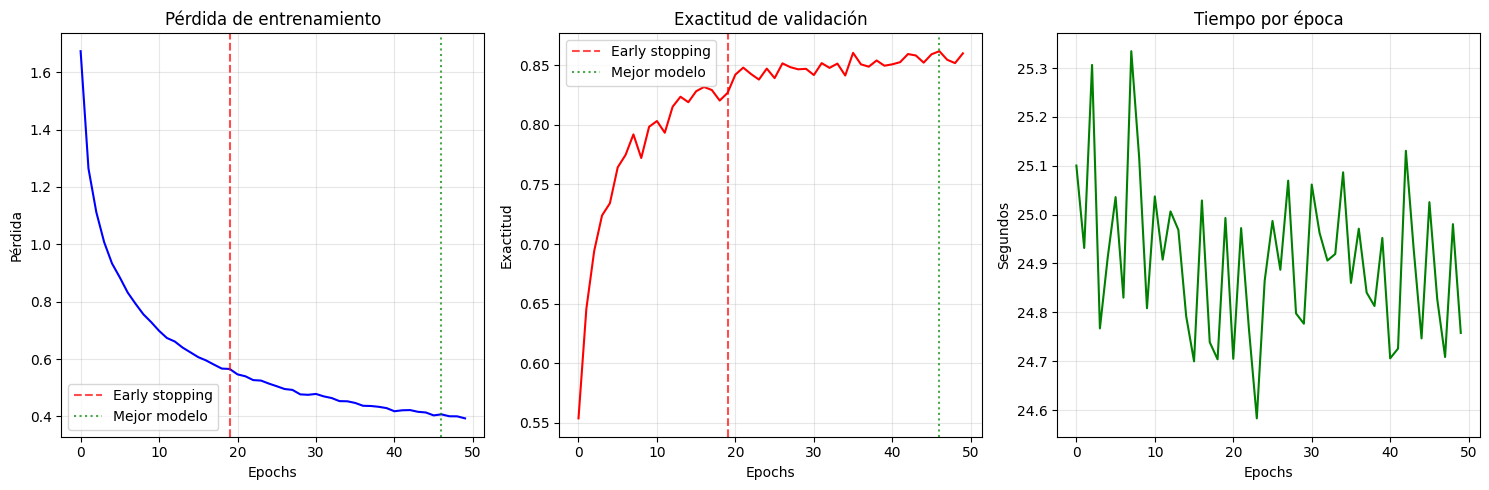

In [54]:
# Ahora podemos visualizar después del entrenamiento
visualize_training_progress(history_cnn, early_stop_epoch_cnn, best_epoch_cnn, "cnn_base")

In [55]:
# Evaluamos en el conjunto de test
test_acc_cnn = accuracy(model_cnn_base, test_loader, device)
print(f"\nExactitud en test (CNN Base): {test_acc_cnn:.4f}")


Exactitud en test (CNN Base): 0.8550


In [56]:
# Guardamos el modelo con su historial
save_model_with_history(
    model_cnn_base,
    optimizer_cnn,
    EPOCHS,
    test_acc_cnn,
    'cnn_base',
    history_cnn
)

Modelo guardado en saved_models/cnn_base.pth


In [57]:
# descargamos modelo con su historial
download_model_from_colab('cnn_base')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo cnn_base descargado correctamente


True

#### 2.3.3 Resultados<a name="cnnbase-res"></a>

El entrenamiento de nuestro modelo CNN base muestra un patrón de aprendizaje progresivo y efectivo. La evolución de la pérdida de entrenamiento sigue una tendencia descendente constante, desde valores iniciales de aproximadamente 1.67 hasta estabilizarse alrededor de 0.39 en las épocas finales.

La exactitud en validación experimenta un incremento gradual y sostenido a lo largo del entrenamiento, partiendo de un 55.38% inicial hasta alcanzar un máximo de 86.18% en la época 46. Aunque el sistema de detención temprana se activó en la época 19, el entrenamiento continuó descubriendo configuraciones de pesos que mejoraban el rendimiento. Esta mejora continua ilustra la capacidad del modelo para perfeccionar su representación de las características discriminativas con mayor exposición a los datos.

Respecto al rendimiento final, el modelo logró una exactitud de 85.50% en el conjunto de prueba, mostrando una ligera reducción comparada con el máximo de validación. Esta diferencia del 0.68% se encuentra dentro de los márgenes esperados y sugiere una generalización adecuada sin indicios de sobreajuste.

Los tiempos de entrenamiento fueron consistentes, manteniéndose principalmente en el rango de 24 a 25 segundos por época, lo que demuestra la estabilidad del proceso y la eficiencia de las técnicas implementadas. Esta constancia permitió completar el entrenamiento completo en aproximadamente 21 minutos.

La gráfica de pérdida muestra que la tendencia descendente continúa incluso en las últimas épocas, por lo que parece que posiblemente un entrenamiento más prolongado podría aportar mejoras adicionales. Sin embargo, la estabilización relativa observada en la exactitud de validación indica que el equilibrio alcanzado es satisfactorio.

### 2.4 Modelo 2: Aprendizaje por transferencia<a name="transfer"></a>





En esta sección implementamos nuestra segunda aproximación al problema de clasificación, utilizando el aprendizaje por transferencia. Esta técnica aprovecha el conocimiento adquirido por modelos previamente entrenados en grandes conjuntos de datos como ImageNet, adaptándolos a nuestra tarea específica con CIFAR-10.

In [28]:
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


#### 2.4.1 Configuración y adapatción del modelo<a name="transfer-conf"></a>

Para nuestra implementación, seleccionamos ResNet18 como arquitectura base. Esta red se caracteriza por sus conexiones residuales, que facilitan el flujo de gradientes durante el entrenamiento de redes profundas y ayudan a mitigar el problema de la degradación del gradiente. El proceso de adaptación requiere varias modificaciones:

1. Congelamos los pesos de todas las capas convolucionales de ResNet18, manteniendo intacto el conocimiento general sobre características visuales adquirido durante su entrenamiento con ImageNet.
2. Sustituimos la capa de clasificación original, diseñada para las 1000 categorías de ImageNet, por una nueva capa totalmente conectada adaptada a nuestras 10 clases de CIFAR-10.

Esta estrategia preserva la capacidad del modelo para extraer características visuales preentrenadas mientras se especializa únicamente en la última capa para nuestra tarea de clasificación específica.

In [29]:
# Congelamos las capas del modelo preentrenado
for param in model_resnet18.parameters():
    param.requires_grad = False

In [30]:
# Mostramos algunas capas
print("Primera capa de ResNet18:")
print(model_resnet18.conv1)
print("\nÚltima capa de ResNet18:")
print(model_resnet18.fc)

Primera capa de ResNet18:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Última capa de ResNet18:
Linear(in_features=512, out_features=1000, bias=True)


In [31]:
# Convertimos el modelo en una secuencia de capas
# pero exluyendo la última capa lineal
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])
model_transfer = nn.Sequential(
    model_aux,
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=10, bias=True)
)

#### 2.4.2 Entrenamiento<a name="transfer-ent"></a>

Para el entrenamiento del modelo de transferencia de aprendizaje, configuramos un optimizador Adam con parámetros ajustados para nuestra tarea: una tasa de aprendizaje de 0.0005, un factor de degradación de pesos (weight decay) de 1e-5 y coeficientes beta de (0.9, 0.999). Estos valores fueron seleccionados tras varias pruebas previas, buscando el equilibrio adecuado para nuestro caso específico.

In [32]:
# Configuramos el optimizador
optimizer_transfer = torch.optim.Adam(model_transfer.parameters(),
                                      lr=0.0005,
                                      weight_decay=1e-5,
                                      betas=(0.9, 0.999))

In [33]:
best_epoch_transfer, best_acc_transfer, model_transfer, history_transfer, early_stop_epoch_transfer = train(
    model_transfer,
    optimizer_transfer,
    train_loader_pretrained,
    val_loader_pretrained,
    device,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name="resnet18_transfer"
)

Output()

Epoch: 0 | Loss: 1.1847 | Val Acc: 0.7350 | Time: 100.38s

✓ Checkpoint guardado en epoch 0 con exactitud 0.7350 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 1 | Loss: 0.8437 | Val Acc: 0.7482 | Time: 97.62s

✓ Checkpoint guardado en epoch 1 con exactitud 0.7482 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 2 | Loss: 0.7876 | Val Acc: 0.7718 | Time: 97.58s

✓ Checkpoint guardado en epoch 2 con exactitud 0.7718 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 3 | Loss: 0.7588 | Val Acc: 0.7746 | Time: 97.51s

✓ Checkpoint guardado en epoch 3 con exactitud 0.7746 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 4 | Loss: 0.7438 | Val Acc: 0.7780 | Time: 97.34s

✓ Checkpoint guardado en epoch 4 con exactitud 0.7780 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 5 | Loss: 0.7361 | Val Acc: 0.7826 | Time: 97.47s

✓ Checkpoint guardado en epoch 5 con exactitud 0.7826 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 6 | Loss: 0.7234 | Val Acc: 0.7808 | Time: 97.93s

Output()

Epoch: 7 | Loss: 0.7215 | Val Acc: 0.7910 | Time: 97.22s

✓ Checkpoint guardado en epoch 7 con exactitud 0.7910 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 8 | Loss: 0.7172 | Val Acc: 0.7862 | Time: 97.39s

Output()

Epoch: 9 | Loss: 0.7101 | Val Acc: 0.7868 | Time: 97.97s

Output()

Epoch: 10 | Loss: 0.7042 | Val Acc: 0.7884 | Time: 97.43s

! Early stopping activado en epoch 10. Mejor epoch: 7 con exactitud 0.7910

  Seguimos entrenando para completar todas las épocas...

Output()

Epoch: 11 | Loss: 0.7017 | Val Acc: 0.7948 | Time: 97.64s

✓ Checkpoint guardado en epoch 11 con exactitud 0.7948 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 12 | Loss: 0.7017 | Val Acc: 0.7866 | Time: 98.08s

Output()

Epoch: 13 | Loss: 0.7037 | Val Acc: 0.7908 | Time: 97.99s

Output()

Epoch: 14 | Loss: 0.6982 | Val Acc: 0.7920 | Time: 97.95s

Output()

Epoch: 15 | Loss: 0.6935 | Val Acc: 0.7942 | Time: 98.04s

Output()

Epoch: 16 | Loss: 0.6893 | Val Acc: 0.7884 | Time: 98.26s

Output()

Epoch: 17 | Loss: 0.6949 | Val Acc: 0.7938 | Time: 98.11s

Output()

Epoch: 18 | Loss: 0.6987 | Val Acc: 0.7898 | Time: 97.84s

Output()

Epoch: 19 | Loss: 0.6941 | Val Acc: 0.7882 | Time: 98.01s

Output()

Epoch: 20 | Loss: 0.6864 | Val Acc: 0.7860 | Time: 98.04s

Output()

Epoch: 21 | Loss: 0.6908 | Val Acc: 0.7904 | Time: 97.47s

Output()

Epoch: 22 | Loss: 0.6877 | Val Acc: 0.7916 | Time: 97.41s

Output()

Epoch: 23 | Loss: 0.6909 | Val Acc: 0.7894 | Time: 97.75s

Output()

Epoch: 24 | Loss: 0.6863 | Val Acc: 0.7918 | Time: 97.59s

Output()

Epoch: 25 | Loss: 0.6837 | Val Acc: 0.7942 | Time: 98.20s

Output()

Epoch: 26 | Loss: 0.6875 | Val Acc: 0.7910 | Time: 97.88s

Output()

Epoch: 27 | Loss: 0.6806 | Val Acc: 0.7912 | Time: 98.16s

Output()

Epoch: 28 | Loss: 0.6834 | Val Acc: 0.7890 | Time: 97.86s

Output()

Epoch: 29 | Loss: 0.6840 | Val Acc: 0.7960 | Time: 97.73s

✓ Checkpoint guardado en epoch 29 con exactitud 0.7960 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 30 | Loss: 0.6781 | Val Acc: 0.7884 | Time: 97.81s

Output()

Epoch: 31 | Loss: 0.6801 | Val Acc: 0.7942 | Time: 97.43s

Output()

Epoch: 32 | Loss: 0.6853 | Val Acc: 0.7968 | Time: 97.84s

✓ Checkpoint guardado en epoch 32 con exactitud 0.7968 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 33 | Loss: 0.6826 | Val Acc: 0.7914 | Time: 97.83s

Output()

Epoch: 34 | Loss: 0.6806 | Val Acc: 0.7940 | Time: 97.56s

Output()

Epoch: 35 | Loss: 0.6799 | Val Acc: 0.7942 | Time: 97.67s

Output()

Epoch: 36 | Loss: 0.6756 | Val Acc: 0.7886 | Time: 97.39s

Output()

Epoch: 37 | Loss: 0.6748 | Val Acc: 0.7952 | Time: 97.76s

Output()

Epoch: 38 | Loss: 0.6752 | Val Acc: 0.7980 | Time: 97.54s

✓ Checkpoint guardado en epoch 38 con exactitud 0.7980 en saved_models/resnet18_transfer_best.pth

Output()

Epoch: 39 | Loss: 0.6784 | Val Acc: 0.7920 | Time: 98.03s

Output()

Epoch: 40 | Loss: 0.6772 | Val Acc: 0.7926 | Time: 97.89s

Output()

Epoch: 41 | Loss: 0.6759 | Val Acc: 0.7944 | Time: 97.20s

Output()

Epoch: 42 | Loss: 0.6821 | Val Acc: 0.7912 | Time: 97.61s

Output()

Epoch: 43 | Loss: 0.6813 | Val Acc: 0.7922 | Time: 97.87s

Output()

Epoch: 44 | Loss: 0.6747 | Val Acc: 0.7954 | Time: 97.71s

Output()

Epoch: 45 | Loss: 0.6794 | Val Acc: 0.7906 | Time: 97.96s

Output()

Epoch: 46 | Loss: 0.6769 | Val Acc: 0.7928 | Time: 97.51s

Output()

Epoch: 47 | Loss: 0.6734 | Val Acc: 0.7930 | Time: 97.65s

Output()

Epoch: 48 | Loss: 0.6718 | Val Acc: 0.7924 | Time: 97.65s

Output()

Epoch: 49 | Loss: 0.6794 | Val Acc: 0.7942 | Time: 97.89s

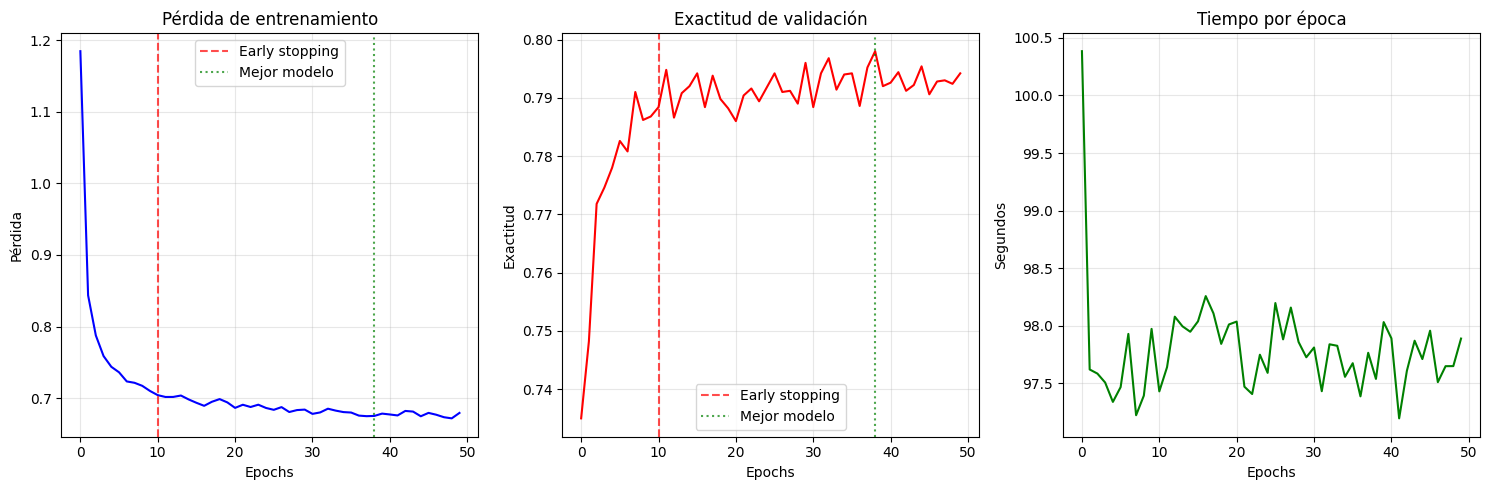

In [34]:
# Ahora podemos visualizar después del entrenamiento
visualize_training_progress(history_transfer, early_stop_epoch_transfer, best_epoch_transfer, "resnet18_transfer")

In [35]:
# Evaluamos en el conjunto de test
test_acc_transfer = accuracy(model_transfer, test_loader_pretrained, device)
print(f"\nExactitud en test (Transfer Learning): {test_acc_transfer:.4f}")


Exactitud en test (Transfer Learning): 0.7857


Durante el proceso de entrenamiento observamos el siguiente  comportamiento en la convergencia del modelo: la pérdida de entrenamiento muestra una disminución constante desde valores iniciales cercanos a 1.2 hasta estabilizarse alrededor de 0.68 en las épocas finales. Sin embargo, la exactitud en validación presenta oscilaciones moderadas, con variaciones de hasta 1-2% entre épocas consecutivas. Esta característica, poco común en nuestro modelo CNN base, sugiere una sensibilidad particular del modelo de transferencia a las variaciones introducidas por el aumento de datos.

El sistema de detención temprana se activó inicialmente en la época 10, pero el entrenamiento continuó descubriendo mejoras posteriores. La mejor exactitud en validación (79.80%) se alcanzó en la época 38, representando una mejora significativa respecto a los valores iniciales pero sin superar el rendimiento de nuestra CNN base.

En cuanto a la eficiencia computacional, los tiempos por época fueron considerablemente mayores (aproximadamente 98 segundos frente a los 27 segundos de la CNN base), lo que refleja la mayor complejidad del modelo ResNet18 y el procesamiento adicional requerido para el redimensionamiento de las imágenes.
El rendimiento final en el conjunto de prueba fue de 78.57%, mostrando una ligera reducción respecto a la exactitud de validación, lo que sugiere una generalización adecuada sin signos evidentes de sobreajuste.

In [36]:
# Guardamos el modelo con su historial
save_model_with_history(
    model_transfer,
    optimizer_transfer,
    EPOCHS,
    test_acc_transfer,
    'resnet18_transfer',
    history_transfer
)

Modelo guardado en saved_models/resnet18_transfer.pth


In [37]:
# descargamos modelo con su historial
download_model_from_colab('resnet18_transfer')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo resnet18_transfer descargado correctamente


True

#### 2.4.3 Resultados<a name="transfer-res"></a>

Los resultados obtenidos muestran que nuestro modelo de transferencia de aprendizaje alcanzó un 78.57% de exactitud en el conjunto de prueba, cifra inferior al 84.95% logrado por la CNN base más simple. Esta diferencia de rendimiento, aunque inicialmente no esperada, puede explicarse por diversos factores técnicos relacionados con la naturaleza de ambos modelos y su interacción con el conjunto de datos CIFAR-10.

La literatura científica documenta casos similares donde arquitecturas más complejas no necesariamente superan a modelos más simples pero mejor adaptados a problemas específicos. En nuestro caso, la diferencia de resolución entre las imágenes de CIFAR-10 (32×32) y las utilizadas para entrenar ResNet18 (224×224) introduce una transformación adicional que puede degradar información relevante para la clasificación.

La complejidad arquitectónica de ResNet18, con sus numerosas capas convolucionales y conexiones residuales, está optimizada para captar jerarquías complejas de características en imágenes de alta resolución y gran variabilidad. Para un conjunto como CIFAR-10, con imágenes pequeñas y categorías bien diferenciadas, esta complejidad podría estar captando patrones irrelevantes o introduciendo ruido en el proceso de clasificación. El fenómeno ilustra el principio de que la complejidad del modelo debe corresponderse con la complejidad inherente de la tarea.

Los experimentos adicionales realizados incluyeron:

1. Incorporación de capas Dropout (0.5) entre la extracción de características y la clasificación
2. Ajustes en la tasa de aprendizaje (reducción a 0.0003) y en la regularización L2 (aumento a 1e-4)
3. Modificación de las transformaciones de aumento de datos para hacerlas menos agresivas

Estas modificaciones no produjeron mejoras significativas en el rendimiento del modelo, lo que refuerza la idea de que la adaptación específica al problema puede ser más determinante que la complejidad arquitectónica. La configuración original se mantuvo como implementación final para este componente del trabajo.

### 2.5 Modelo 3: Ajuste fino (fine-tuning) de ResNet18<a name="fine"></a>

El ajuste fino representa una técnica más avanzada que el transfer learning básico, permitiendo que algunas capas del modelo preentrenado se adapten a nuestros datos. Para esta implementación, modificamos nuestra aproximación anterior en la conexión con la capa de clasificación.


#### 2.5.1 Configuarción y adaptación del modelo<a name="fine-conf"></a>

En lugar de crear una secuencia de módulos como hicimos en el transfer learning, mantenemos la estructura original de ResNet18 intacta. Esta decisión nos proporciona varias ventajas:

1. Acceso directo a capas específicas para el ajuste fino selectivo
2. Mantenimiento de la estructura residual original
3. Simplificación de la manipulación de las capas individuales

La sustitución de la capa de clasificación se realiza directamente sobre el modelo:
- Identificamos el número de características de entrada de la capa final
- Reemplazamos la capa fully connected con una nueva adaptada a nuestras 10 clases

In [38]:
# Cargamos ResNet18 preentrenado
model_fine_tuning = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Primero congelamos todas las capas
for param in model_fine_tuning.parameters():
    param.requires_grad = False

# Descongelamos las dos últimas capas convolucionales (layer3 y layer4)
for param in model_fine_tuning.layer3.parameters():
    param.requires_grad = True
for param in model_fine_tuning.layer4.parameters():
    param.requires_grad = True

# Reemplazamos la última capa fully connected
num_features = model_fine_tuning.fc.in_features
model_fine_tuning.fc = nn.Linear(num_features, 10)

#### 2.5.2 Entrenamiento<a name="fine-ent"></a>



Para el entrenamiento de nuestro modelo con ajuste fino, implementamos una estrategia de optimización diferenciada que reconoce la distinta naturaleza de las capas que estamos entrenando. Configuramos el optimizador Adam con tasas de aprendizaje específicas para cada grupo de parámetros:

- 0.0001 para los parámetros de la capa residual 3 (layer3)
- 0.0001 para los parámetros de la capa residual 4 (layer4)
- 0.001 para los parámetros de la capa de clasificación (fc)

Esta configuración proporciona un balance entre preservación y adaptación: las tasas más bajas para las capas convolucionales preservan el conocimiento general ya adquirido, mientras que la tasa más alta para la capa de clasificación facilita la adaptación a nuestras categorías específicas.

In [39]:
# Optimizador con learning rate diferenciado
optimizer_fine_tuning = torch.optim.Adam([
    {'params': model_fine_tuning.layer3.parameters(), 'lr': 0.0001},  # lr bajo para layer3
    {'params': model_fine_tuning.layer4.parameters(), 'lr': 0.0001},  # lr bajo para layer4
    {'params': model_fine_tuning.fc.parameters(), 'lr': 0.001}        # lr alto para capa nueva
])

# Entrenamiento con precisión mixta y early stopping
best_epoch_finetuning, best_acc_finetuning, model_fine_tuning, history_finetuning, early_stop_epoch_finetuning = train(
    model_fine_tuning,
    optimizer_fine_tuning,
    train_loader_pretrained,
    val_loader_pretrained,
    device,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name="resnet18_finetuning"
)

Output()

Epoch: 0 | Loss: 0.4323 | Val Acc: 0.9138 | Time: 99.47s

✓ Checkpoint guardado en epoch 0 con exactitud 0.9138 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 1 | Loss: 0.2210 | Val Acc: 0.9296 | Time: 97.87s

✓ Checkpoint guardado en epoch 1 con exactitud 0.9296 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 2 | Loss: 0.1651 | Val Acc: 0.9302 | Time: 98.33s

✓ Checkpoint guardado en epoch 2 con exactitud 0.9302 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 3 | Loss: 0.1263 | Val Acc: 0.9392 | Time: 98.62s

✓ Checkpoint guardado en epoch 3 con exactitud 0.9392 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 4 | Loss: 0.1116 | Val Acc: 0.9332 | Time: 98.08s

Output()

Epoch: 5 | Loss: 0.0894 | Val Acc: 0.9346 | Time: 98.27s

Output()

Epoch: 6 | Loss: 0.0817 | Val Acc: 0.9378 | Time: 98.17s

! Early stopping activado en epoch 6. Mejor epoch: 3 con exactitud 0.9392

  Seguimos entrenando para completar todas las épocas...

Output()

Epoch: 7 | Loss: 0.0764 | Val Acc: 0.9396 | Time: 98.16s

✓ Checkpoint guardado en epoch 7 con exactitud 0.9396 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 8 | Loss: 0.0694 | Val Acc: 0.9380 | Time: 98.29s

Output()

Epoch: 9 | Loss: 0.0630 | Val Acc: 0.9442 | Time: 98.40s

✓ Checkpoint guardado en epoch 9 con exactitud 0.9442 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 10 | Loss: 0.0595 | Val Acc: 0.9352 | Time: 98.06s

Output()

Epoch: 11 | Loss: 0.0562 | Val Acc: 0.9440 | Time: 98.43s

Output()

Epoch: 12 | Loss: 0.0565 | Val Acc: 0.9428 | Time: 97.81s

Output()

Epoch: 13 | Loss: 0.0461 | Val Acc: 0.9404 | Time: 97.99s

Output()

Epoch: 14 | Loss: 0.0440 | Val Acc: 0.9414 | Time: 97.80s

Output()

Epoch: 15 | Loss: 0.0427 | Val Acc: 0.9418 | Time: 98.16s

Output()

Epoch: 16 | Loss: 0.0429 | Val Acc: 0.9402 | Time: 98.20s

Output()

Epoch: 17 | Loss: 0.0411 | Val Acc: 0.9398 | Time: 97.63s

Output()

Epoch: 18 | Loss: 0.0465 | Val Acc: 0.9478 | Time: 97.95s

✓ Checkpoint guardado en epoch 18 con exactitud 0.9478 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 19 | Loss: 0.0414 | Val Acc: 0.9470 | Time: 98.32s

Output()

Epoch: 20 | Loss: 0.0337 | Val Acc: 0.9378 | Time: 98.00s

Output()

Epoch: 21 | Loss: 0.0344 | Val Acc: 0.9408 | Time: 97.84s

Output()

Epoch: 22 | Loss: 0.0332 | Val Acc: 0.9452 | Time: 97.87s

Output()

Epoch: 23 | Loss: 0.0348 | Val Acc: 0.9358 | Time: 97.99s

Output()

Epoch: 24 | Loss: 0.0344 | Val Acc: 0.9458 | Time: 97.87s

Output()

Epoch: 25 | Loss: 0.0318 | Val Acc: 0.9416 | Time: 98.59s

Output()

Epoch: 26 | Loss: 0.0299 | Val Acc: 0.9442 | Time: 98.20s

Output()

Epoch: 27 | Loss: 0.0287 | Val Acc: 0.9406 | Time: 98.63s

Output()

Epoch: 28 | Loss: 0.0313 | Val Acc: 0.9458 | Time: 98.50s

Output()

Epoch: 29 | Loss: 0.0267 | Val Acc: 0.9436 | Time: 98.13s

Output()

Epoch: 30 | Loss: 0.0267 | Val Acc: 0.9394 | Time: 98.29s

Output()

Epoch: 31 | Loss: 0.0292 | Val Acc: 0.9418 | Time: 97.96s

Output()

Epoch: 32 | Loss: 0.0285 | Val Acc: 0.9440 | Time: 97.92s

Output()

Epoch: 33 | Loss: 0.0259 | Val Acc: 0.9480 | Time: 98.45s

✓ Checkpoint guardado en epoch 33 con exactitud 0.9480 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 34 | Loss: 0.0242 | Val Acc: 0.9446 | Time: 98.13s

Output()

Epoch: 35 | Loss: 0.0243 | Val Acc: 0.9436 | Time: 98.22s

Output()

Epoch: 36 | Loss: 0.0259 | Val Acc: 0.9492 | Time: 98.43s

✓ Checkpoint guardado en epoch 36 con exactitud 0.9492 en saved_models/resnet18_finetuning_best.pth

Output()

Epoch: 37 | Loss: 0.0226 | Val Acc: 0.9380 | Time: 98.10s

Output()

Epoch: 38 | Loss: 0.0234 | Val Acc: 0.9434 | Time: 98.16s

Output()

Epoch: 39 | Loss: 0.0235 | Val Acc: 0.9478 | Time: 98.33s

Output()

Epoch: 40 | Loss: 0.0269 | Val Acc: 0.9484 | Time: 97.68s

Output()

Epoch: 41 | Loss: 0.0205 | Val Acc: 0.9438 | Time: 98.53s

Output()

Epoch: 42 | Loss: 0.0184 | Val Acc: 0.9492 | Time: 97.86s

Output()

Epoch: 43 | Loss: 0.0242 | Val Acc: 0.9478 | Time: 98.61s

Output()

Epoch: 44 | Loss: 0.0193 | Val Acc: 0.9446 | Time: 98.04s

Output()

Epoch: 45 | Loss: 0.0228 | Val Acc: 0.9420 | Time: 98.21s

Output()

Epoch: 46 | Loss: 0.0247 | Val Acc: 0.9422 | Time: 98.24s

Output()

Epoch: 47 | Loss: 0.0181 | Val Acc: 0.9442 | Time: 98.25s

Output()

Epoch: 48 | Loss: 0.0181 | Val Acc: 0.9434 | Time: 98.30s

Output()

Epoch: 49 | Loss: 0.0162 | Val Acc: 0.9440 | Time: 98.36s

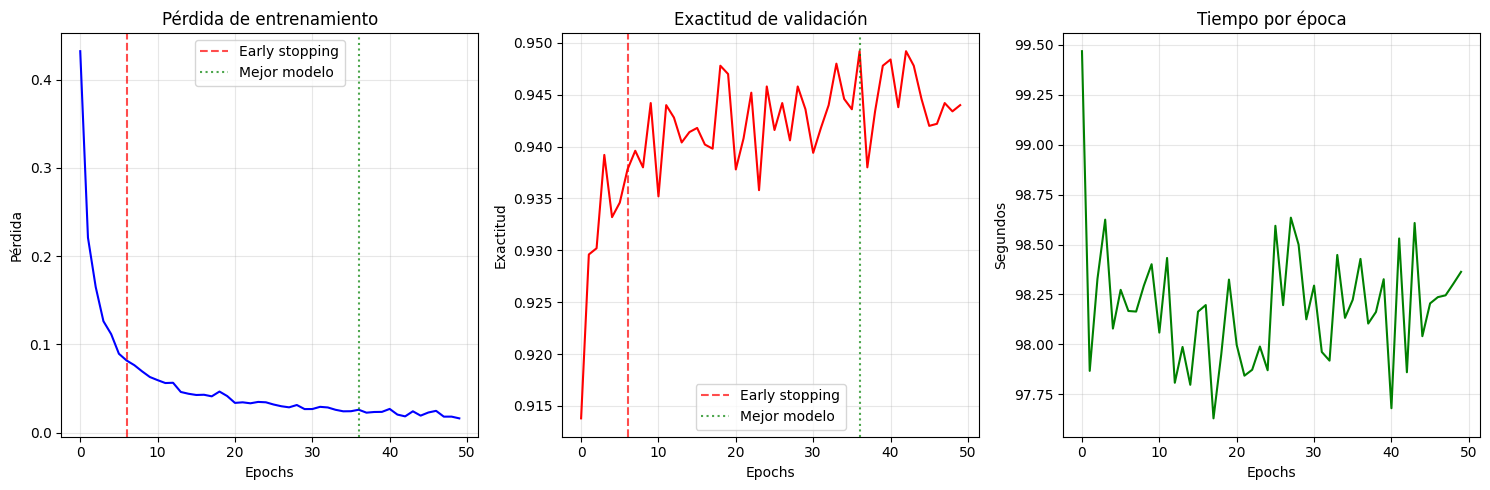

In [40]:
# Visualización para Transfer Learning
visualize_training_progress(history_finetuning, early_stop_epoch_finetuning, best_epoch_finetuning, "resnet18_finetuning")

Los resultados del entrenamiento muestran una convergencia eficiente. La pérdida de entrenamiento descendió desde un valor inicial de 0.43 hasta estabilizarse por debajo de 0.02 en las épocas finales. Esta reducción refleja la eficacia de combinar características preentrenadas con un ajuste fino específico para nuestra tarea.

La exactitud en validación mostró un comportamiento igualmente positivo, comenzando en 91.38% desde la primera época y alcanzando un máximo de 94.92% en la época 36. El sistema de detención temprana se activó inicialmente en la época 6, pero el entrenamiento continuó encontrando configuraciones de pesos que mejoraban el rendimiento. Esta capacidad para seguir refinando el modelo incluso después de una buena exactitud inicial muestra las ventajas del ajuste fino para optimizar el rendimiento.
Los tiempos de entrenamiento se mantuvieron consistentes alrededor de 98 segundos por época, similares a los observados en el modelo de transferencia de aprendizaje básico. Esta consistencia temporal indica que nuestras modificaciones arquitectónicas no introducen una sobrecarga computacional adicional.

In [41]:
# Evaluamos en el conjunto de test
test_acc_finetuning = accuracy(model_fine_tuning, test_loader_pretrained, device)
print(f"\nExactitud en test (Fine-tuning): {test_acc_finetuning:.4f}")


Exactitud en test (Fine-tuning): 0.9428


In [42]:
# Guardamos el modelo
save_model_with_history(
    model_fine_tuning,
    optimizer_fine_tuning,
    EPOCHS,
    test_acc_finetuning,
    'resnet18_finetuning',
    history_finetuning
)

Modelo guardado en saved_models/resnet18_finetuning.pth


In [44]:
# descargamos modelo con su historial
download_model_from_colab('resnet18_finetuning')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo resnet18_finetuning descargado correctamente


True

#### 2.5.3 Resultados<a name="fine-res"></a>

El modelo con ajuste fino alcanzó una exactitud de 94.28% en el conjunto de prueba, lo que representa una mejora respecto al modelo CNN base (84.95%) y al modelo de transferencia de aprendizaje (78.57%). Este resultado muestra las ventajas del ajuste fino cuando se aplica a tareas de clasificación de imágenes.

La descongelación selectiva de capas permite que el modelo adapte características específicas para CIFAR-10, mientras mantiene las características aprendidas de ImageNet.

Las tasas de aprendizaje diferenciadas permiten un proceso de adaptación más controlado, evitando alteraciones en las características aprendidas previamente y permitiendo, al mismo tiempo, que la capa de clasificación se especialice.

La preservación de la estructura original de ResNet18, incluyendo sus conexiones residuales, facilita el flujo de gradientes durante el retroproceso, lo que contribuye a un entrenamiento estable.

La curva de aprendizaje muestra una característica común en los modelos con ajuste fino: una mejora inicial rápida seguida de una fase de refinamiento más gradual. Esta pauta contrasta con la curva más lineal observada en nuestra CNN base, indicando que el ajuste fino utiliza el conocimiento preexistente para iniciar el aprendizaje desde un punto más avanzado.

Las fluctuaciones observadas en la exactitud de validación están presentes en los tres modelos. Aunque en términos absolutos las oscilaciones del modelo de ajuste fino pueden parecer menores, proporcionalmente representan variaciones similares.

El tiempo requerido para alcanzar ciertos niveles de exactitud también fue menor: mientras la CNN base necesitó más de 40 épocas para superar el 86% de exactitud, el modelo con ajuste fino alcanzó el 93% en 3 épocas.


### 2.6 Comparativa de resultados<a name="comparativa"></a>

---
#### Cargamos y creamos los modelos previamente guardados
---

In [19]:
# Definimos los modelos vacíos para cargarlos
model_cnn_base = nn.Sequential(
    CNN_class(3, channel1, channel2),
    CNN_class(channel2, channel4, channel4),
    nn.Flatten(),
    nn.Linear(in_features=8*8*channel4, out_features=10)
)
optimizer_cnn = torch.optim.Adam(model_cnn_base.parameters(), lr=0.001)

# Modelo de transferencia
model_aux = nn.Sequential(*list(models.resnet18().children())[:-1])
# Congelar parámetros del modelo base
for param in model_aux.parameters():
    param.requires_grad = False
model_transfer = nn.Sequential(
    model_aux,
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=10, bias=True)
)
optimizer_transfer = torch.optim.Adam(model_transfer.parameters(), lr=0.0005)

# Modelo de ajuste fino
model_fine_tuning = models.resnet18()
num_features = model_fine_tuning.fc.in_features
model_fine_tuning.fc = nn.Linear(num_features, 10)
optimizer_fine_tuning = torch.optim.Adam([
    {'params': model_fine_tuning.layer3.parameters(), 'lr': 0.0001},
    {'params': model_fine_tuning.layer4.parameters(), 'lr': 0.0001},
    {'params': model_fine_tuning.fc.parameters(), 'lr': 0.001}
])

# Cargamos los modelos guardados
model_cnn_base, optimizer_cnn, epoch_cnn, accuracy_cnn, history_cnn = load_model(
    model_cnn_base, optimizer_cnn, "cnn_base", device)

model_transfer, optimizer_transfer, epoch_transfer, accuracy_transfer, history_transfer = load_model(
    model_transfer, optimizer_transfer, "resnet18_transfer", device)

model_fine_tuning, optimizer_fine_tuning, epoch_fine_tuning, accuracy_fine_tuning, history_fine_tuning = load_model(
    model_fine_tuning, optimizer_fine_tuning, "resnet18_finetuning", device)


Modelo cnn_base cargado:
Época: 50
Precisión: 0.8550
Modelo resnet18_transfer cargado:
Época: 50
Precisión: 0.7857
Modelo resnet18_finetuning cargado:
Época: 50
Precisión: 0.9428


La finalidad de esta sección es analizar comparativamente los tres modelos implementados, evaluando su rendimiento, eficiencia computacional y características de aprendizaje. Las **figuras 4, 5 y 6**, junto con la **tabla 6** presentadas a continuación, muestran los resultados de nuestras experimentaciones.

In [30]:
# Recopilación automática de información tras cargar los modelos
models_info = {
    "CNN Base": {
        'model': model_cnn_base,
        'val_acc': history_cnn.get('best_val_acc', accuracy_cnn),  # Usamos val_acc del historial si está disponible
        'test_acc': accuracy_cnn,
        'history': history_cnn,
        'epochs': epoch_cnn + 1,  # +1 porque epoch es 0-indexado
        'best_epoch': history_cnn.get('best_epoch', epoch_cnn)  # Usamos mejor época del historial si está disponible
    },
    "Transfer Learning": {
        'model': model_transfer,
        'val_acc': history_transfer.get('best_val_acc', accuracy_transfer),
        'test_acc': accuracy_transfer,
        'history': history_transfer,
        'epochs': epoch_transfer + 1,
        'best_epoch': history_transfer.get('best_epoch', epoch_transfer)
    },
    "Fine-tuning": {
        'model': model_fine_tuning,
        'val_acc': history_fine_tuning.get('best_val_acc', accuracy_fine_tuning),
        'test_acc': accuracy_fine_tuning,
        'history': history_fine_tuning,
        'epochs': epoch_fine_tuning + 1,
        'best_epoch': history_fine_tuning.get('best_epoch', epoch_fine_tuning)
    }
}

# Asegurar que los dispositivos de los modelos sean consistentes
for info in models_info.values():
    info['model'] = info['model'].to(device)

# Imprimir la información recopilada para verificar
for name, info in models_info.items():
    print(f"\nModelo: {name}")
    print(f"Exactitud en validación: {info['val_acc']:.4f}")
    print(f"Exactitud en test: {info['test_acc']:.4f}")
    print(f"Épocas totales: {info['epochs'] - 1}")
    print(f"Mejor época: {info['best_epoch']}")
    print("-" * 50)  # Línea de separación en consola


Modelo: CNN Base
Exactitud en validación: 0.8550
Exactitud en test: 0.8550
Épocas totales: 50
Mejor época: 46
--------------------------------------------------

Modelo: Transfer Learning
Exactitud en validación: 0.7857
Exactitud en test: 0.7857
Épocas totales: 50
Mejor época: 38
--------------------------------------------------

Modelo: Fine-tuning
Exactitud en validación: 0.9428
Exactitud en test: 0.9428
Épocas totales: 50
Mejor época: 36
--------------------------------------------------


#### Comparativa de exactitud

In [20]:
def plot_accuracy_comparison(models_info, fig_num=4):
    """
    Genera una gráfica comparando la exactitud de validación y prueba para cada modelo.
    
    Args:
        models_info: Diccionario con información de cada modelo
        fig_num: Número de figura
    """
    model_names = list(models_info.keys())
    val_accuracies = [info['val_acc'] for info in models_info.values()]
    test_accuracies = [info['test_acc'] for info in models_info.values()]
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, val_accuracies, width, label='Validación', color='cornflowerblue')
    plt.bar(x + width/2, test_accuracies, width, label='Test', color='lightcoral')
    
    plt.ylabel('Exactitud')
    plt.title(f'Figura {fig_num}: Comparativa de exactitud entre modelos')
    plt.xticks(x, model_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Añadir etiquetas de valores
    for i, v in enumerate(val_accuracies):
        plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    for i, v in enumerate(test_accuracies):
        plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('saved_models/accuracy_comparison.png')
    plt.show()

#### Comparativa de las curvas de aprendizaje

In [21]:
def plot_learning_curves(models_info, fig_num=5):
    """
    Genera gráficas comparando las curvas de aprendizaje de todos los modelos.
    
    Args:
        models_info: Diccionario con información de cada modelo
        fig_num: Número de figura
    """
    plt.figure(figsize=(15, 5))
    
    # Pérdida de entrenamiento
    plt.subplot(1, 2, 1)
    for name, info in models_info.items():
        plt.plot(info['history']['train_loss'], label=name)
    plt.title('Pérdida de entrenamiento')
    plt.xlabel('Epochs')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Exactitud de validación
    plt.subplot(1, 2, 2)
    for name, info in models_info.items():
        plt.plot(info['history']['val_accuracy'], label=name)
    plt.title('Exactitud de validación')
    plt.xlabel('Epochs')
    plt.ylabel('Exactitud')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Figura {fig_num}: Curvas de aprendizaje para los tres modelos')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Ajuste para dejar espacio al título principal
    plt.savefig('saved_models/learning_curves_comparison.png')
    plt.show()

#### Comparativa de las métricas

In [22]:
def display_metrics_table(models_info, table_num=6):
    """
    Genera una tabla comparativa con métricas clave de todos los modelos.
    
    Args:
        models_info: Diccionario con información de cada modelo
        table_num: Número de tabla
    """
    headers = ['Modelo', 'Val Acc', 'Test Acc', 'Épocas', 'Mejor Época']
    data = []
    
    for name, info in models_info.items():
        data.append([
            name,
            f"{info['val_acc']:.4f}",
            f"{info['test_acc']:.4f}",
            info['epochs'],
            info['best_epoch']
        ])
    
    print(f"\nTabla {table_num}: Comparativa de métricas entre modelos")
    print(tabulate(data, headers=headers, tablefmt="grid"))

#### Comparativa del número de parámetros entrenables de los modelos

In [23]:
def plot_trainable_parameters(models_info, fig_num=6):
    """
    Genera una gráfica comparando el número de parámetros entrenables de cada modelo.
    
    Args:
        models_info: Diccionario con información de cada modelo
        fig_num: Número de figura
    """
    model_names = list(models_info.keys())
    trainable_params = []
    
    for name, info in models_info.items():
        model = info['model']
        params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        trainable_params.append(params)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, trainable_params, color='mediumseagreen')
    
    plt.title(f'Figura {fig_num}: Parámetros entrenables por modelo')
    plt.xlabel('Modelo')
    plt.ylabel('Número de parámetros')
    plt.yscale('log')  # Escala logarítmica para mejor visualización
    plt.grid(True, alpha=0.3)
    
    # Añadir etiquetas
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('saved_models/model_parameters.png')
    plt.show()

#### Comparativa de las matrices de confusión

In [24]:
def plot_confusion_matrices(models_info, test_loaders, device, class_names, fig_num=7, table_num=7):
    """
    Genera y visualiza matrices de confusión para todos los modelos.
    
    Args:
        models_info: Diccionario con información de cada modelo
        test_loaders: Diccionario con el loader adecuado para cada modelo
        device: Dispositivo para realizar las predicciones
        class_names: Lista con los nombres de las clases
        fig_num: Número de figura
        table_num: Número de tabla para las confusiones
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Definimos una función auxiliar para obtener predicciones
    def get_predictions(model, data_loader):
        model.eval()
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                
        return np.array(all_preds), np.array(all_targets)
    
    # Creamos una figura para todas las matrices
    fig, axes = plt.subplots(1, len(models_info), figsize=(18, 6))
    
    # Si solo hay un modelo, convertimos axes en lista para mantener consistencia
    if len(models_info) == 1:
        axes = [axes]
    
    # Para cada modelo, generamos su matriz de confusión
    for i, (name, info) in enumerate(models_info.items()):
        model = info['model'].to(device)
        
        # Obtenemos predicciones usando el loader adecuado para este modelo
        loader = test_loaders[name]
        y_pred, y_true = get_predictions(model, loader)
        
        # Calculamos la matriz de confusión
        cm = confusion_matrix(y_true, y_pred)
        
        # Normalizamos por filas (verdaderas etiquetas)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Configuramos el mapa de calor
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names, 
                    ax=axes[i], cbar=False)
        
        # Etiquetas y título
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Realidad')
        axes[i].set_title(f'{name}\nExactitud: {info["test_acc"]:.4f}')
        
        # Ajustamos etiquetas para mejor visualización
        axes[i].set_xticklabels(class_names, rotation=45, ha='right')
        axes[i].set_yticklabels(class_names, rotation=0)
    
    # Título general
    plt.suptitle(f'Figura {fig_num}: Matrices de confusión normalizadas para los modelos', 
                fontsize=16)
    
    # Ajustamos espacios
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Guardamos la figura
    plt.savefig('saved_models/confusion_matrices.png', bbox_inches='tight', dpi=200)
    plt.show()
    
    # Adicionalmente, generamos una tabla con las clases más confundidas
    print(f"\nTabla {table_num}: Clases más frecuentemente confundidas por cada modelo")
    
    confusion_data = []
    for name, info in models_info.items():
        model = info['model'].to(device)
        loader = test_loaders[name]
        y_pred, y_true = get_predictions(model, loader)
        cm = confusion_matrix(y_true, y_pred)
        
        # Encontramos las 3 confusiones más comunes (excluyendo la diagonal)
        np.fill_diagonal(cm, 0)  # Ignoramos la diagonal (aciertos)
        
        # Encontramos los 3 valores más altos y sus índices
        top_confusions = []
        for _ in range(3):
            if np.max(cm) > 0:
                true_idx, pred_idx = np.unravel_index(np.argmax(cm), cm.shape)
                count = cm[true_idx, pred_idx]
                top_confusions.append(f"{class_names[true_idx]} → {class_names[pred_idx]} ({count})")
                cm[true_idx, pred_idx] = 0  # Marcamos esta confusión como procesada
            else:
                top_confusions.append("N/A")
        
        confusion_data.append([name] + top_confusions)
    
    # Mostramos la tabla
    headers = ["Modelo", "1ª Confusión", "2ª Confusión", "3ª Confusión"]
    print(tabulate(confusion_data, headers=headers, tablefmt="grid"))

#### Función para la ejecución de las comparativas

In [25]:
def visualize_all_model_results(models_info, test_loader, device, class_names, fig_start_num=4, table_start_num=6):
    """
    Función principal que ejecuta todas las visualizaciones comparativas.
    
    Args:
        models_info: Diccionario con información de cada modelo
        test_loader: Diccionario con el loader adecuado para cada modelo
        device: Dispositivo para realizar las predicciones
        class_names: Lista con los nombres de las clases
        fig_start_num: Número inicial para las figuras
        table_start_num: Número inicial para las tablas
    """
    # 1. Gráfica de exactitud
    plot_accuracy_comparison(models_info, fig_start_num)
    
    # 2. Curvas de aprendizaje
    plot_learning_curves(models_info, fig_start_num + 1)
    
    # 3. Tabla de métricas
    display_metrics_table(models_info, table_start_num)
    
    # 4. Gráfica de parámetros entrenables
    plot_trainable_parameters(models_info, fig_start_num + 2)
    
    # 5. Matrices de confusión y tabla de confusiones
    plot_confusion_matrices(models_info, test_loader, device, class_names, 
                           fig_start_num + 3, table_start_num + 1)

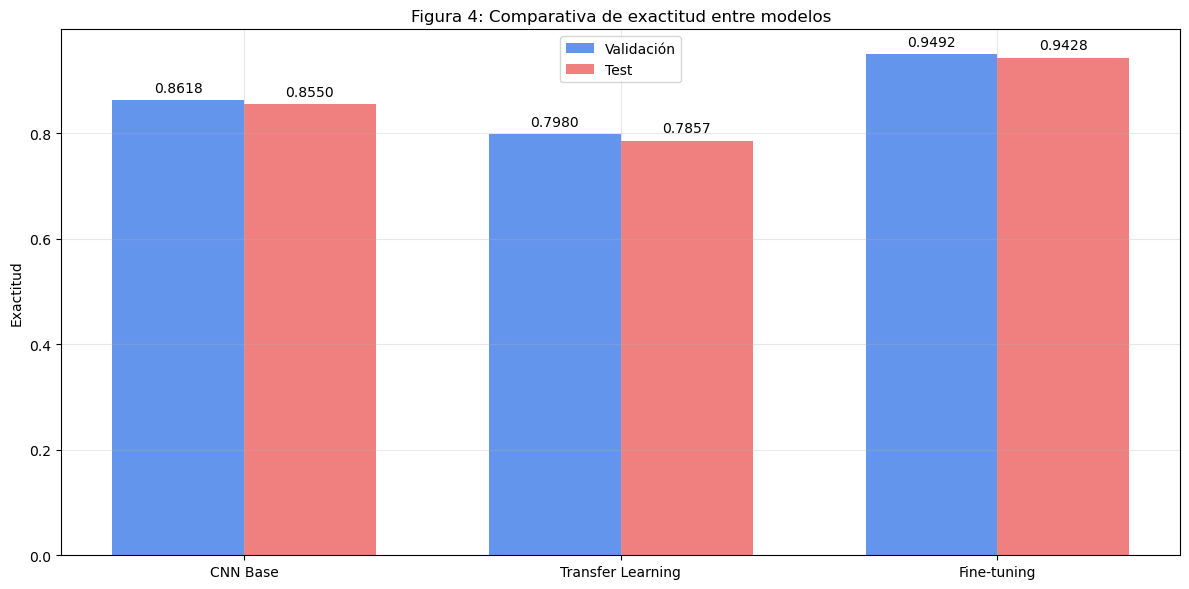

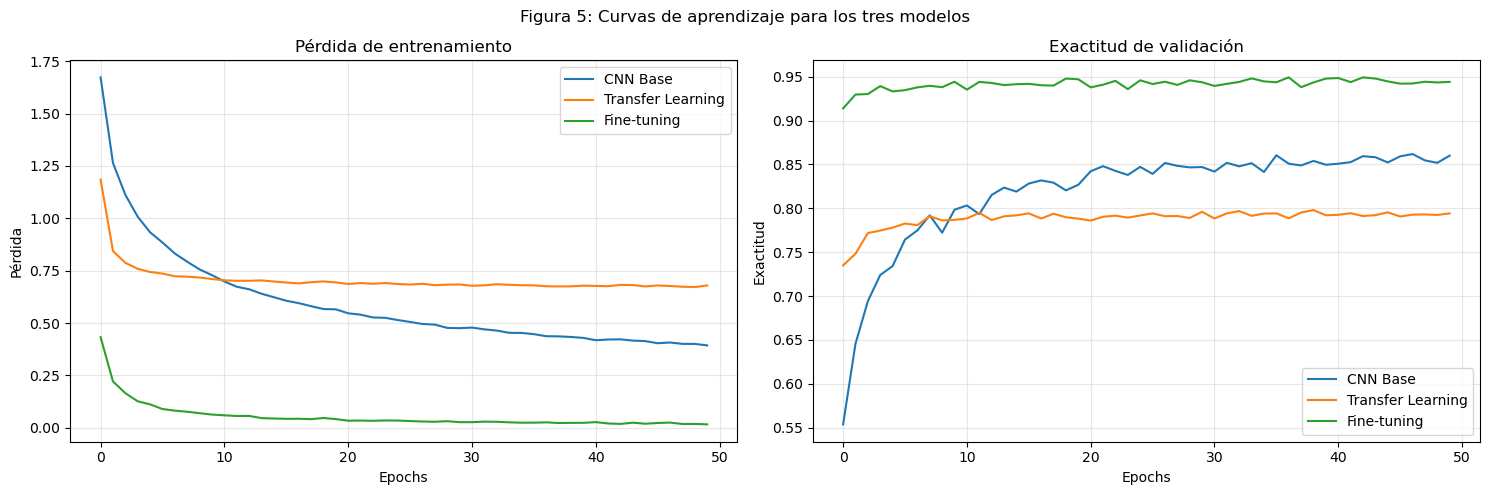


Tabla 6: Comparativa de métricas entre modelos
+-------------------+-----------+------------+----------+---------------+
| Modelo            |   Val Acc |   Test Acc |   Épocas |   Mejor Época |
+===================+===========+============+==========+===============+
| CNN Base          |    0.8618 |     0.855  |       51 |            46 |
+-------------------+-----------+------------+----------+---------------+
| Transfer Learning |    0.798  |     0.7857 |       51 |            38 |
+-------------------+-----------+------------+----------+---------------+
| Fine-tuning       |    0.9492 |     0.9428 |       51 |            36 |
+-------------------+-----------+------------+----------+---------------+


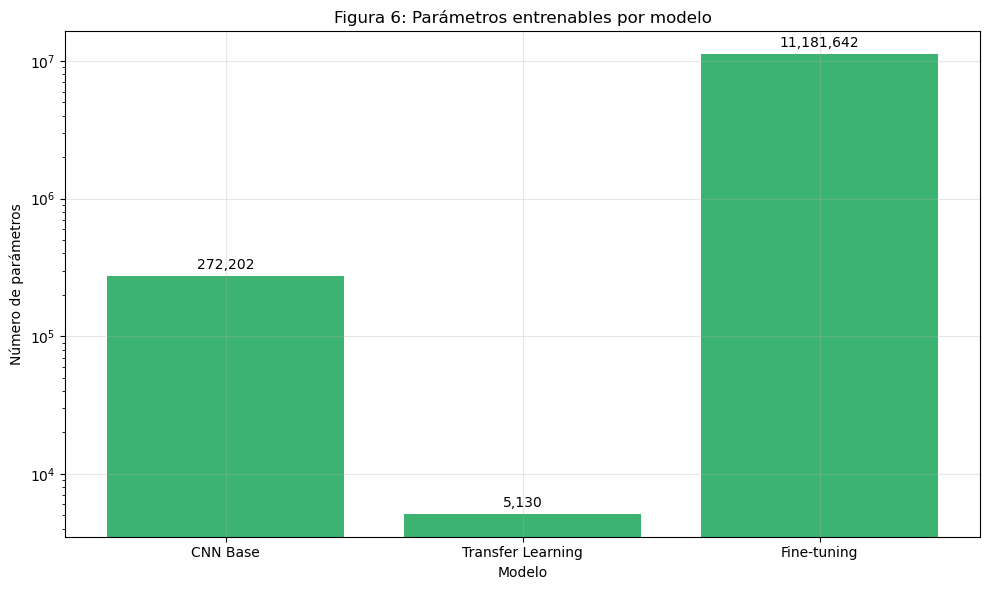

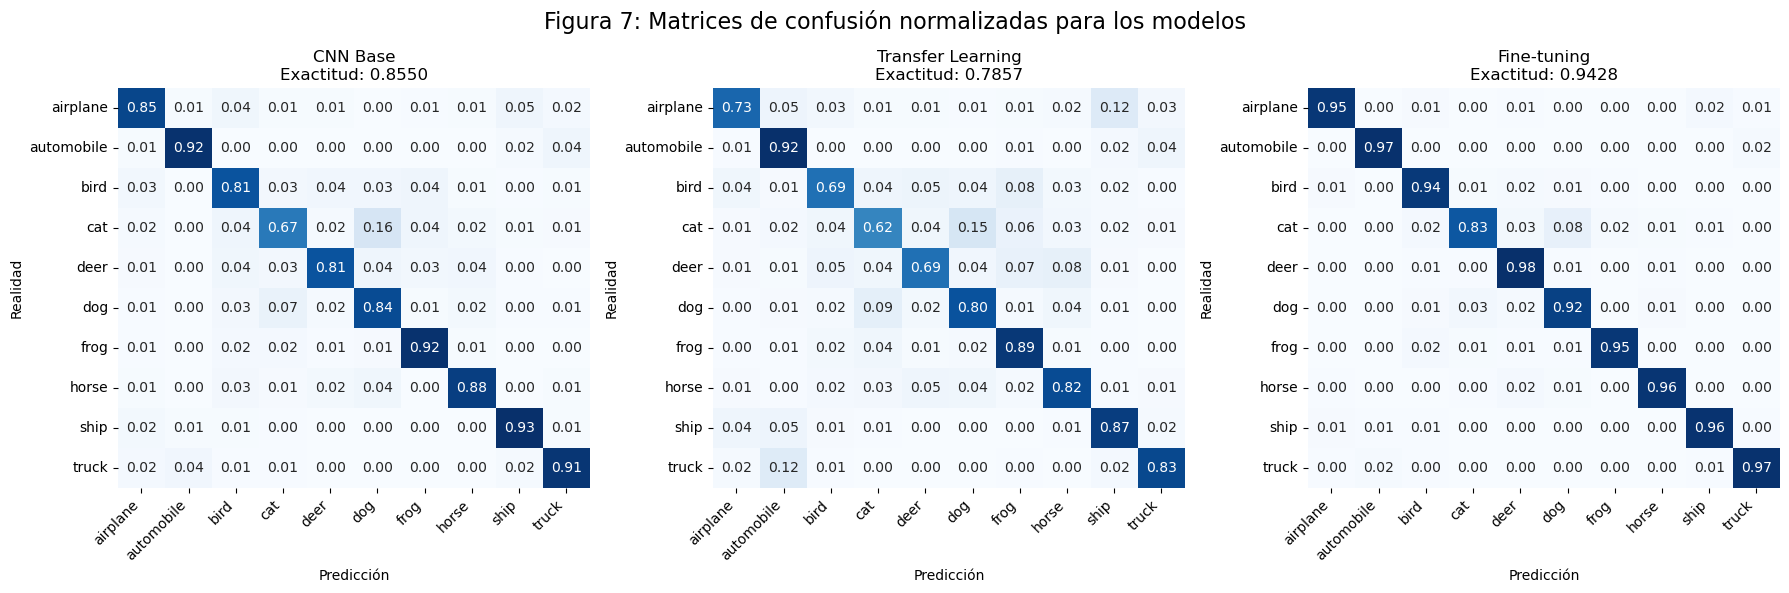


Tabla 7: Clases más frecuentemente confundidas por cada modelo
+-------------------+-----------------+-----------------------+--------------------------+
| Modelo            | 1ª Confusión    | 2ª Confusión          | 3ª Confusión             |
+===================+=================+=======================+==========================+
| CNN Base          | cat → dog (158) | dog → cat (69)        | airplane → ship (47)     |
+-------------------+-----------------+-----------------------+--------------------------+
| Transfer Learning | cat → dog (151) | airplane → ship (120) | truck → automobile (117) |
+-------------------+-----------------+-----------------------+--------------------------+
| Fine-tuning       | cat → dog (84)  | dog → cat (34)        | cat → deer (25)          |
+-------------------+-----------------+-----------------------+--------------------------+


In [28]:
# Definir class_names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Llamar a la función principal con todos los argumentos necesarios
# Al llamar a la función principal:
visualize_all_model_results(
    models_info=models_info,
    test_loader={
        "CNN Base": test_loader,
        "Transfer Learning": test_loader_pretrained,
        "Fine-tuning": test_loader_pretrained
    },
    device=device,
    class_names=class_names
)

#### 2.6.1 Análisis de exactitud<a name="analisis-exactitud"></a>

La **figura 4** muestra la comparativa de exactitud entre nuestros tres modelos, tanto en validación como en prueba:

- El modelo de ajuste fino (fine-tuning) alcanzó 94.92% en validación y 94.28% en prueba.
- La CNN base obtuvo 86.18% en validación y 85.50% en prueba.
- El modelo de transferencia de aprendizaje logró 79.80% en validación y 78.57% en prueba.

Estos resultados muestran que el modelo de transferencia de aprendizaje, donde solo entrenamos la capa de clasificación y mantenemos congelado todo el extractor de características, obtiene un rendimiento inferior al de nuestra CNN base.

La **figura 5** permite examinar el proceso de aprendizaje de los tres modelos. En la gráfica de pérdida de entrenamiento (izquierda), el modelo de ajuste fino alcanza valores bajos de pérdida desde las primeras épocas. La CNN base muestra una disminución gradual de la pérdida, mientras que el modelo de transferencia de aprendizaje se estabiliza en valores intermedios.

La gráfica de exactitud de validación (derecha) muestra patrones distintos:

- El modelo de ajuste fino inicia con exactitud cercana al 90% y rápidamente supera el 94%.
- La CNN base comienza en valores más bajos pero mejora constantemente hasta superar el 85%.
- El modelo de transferencia de aprendizaje inicia en valores intermedios y se estabiliza alrededor del 79%.

La variabilidad en las curvas de exactitud durante el entrenamiento difiere entre modelos, auque es bastante similar, en general

#### 2.6.2 Análisis de eficiencia computacional<a name="analisis-eficiencia"></a>

La **tabla 6** proporciona un resumen de las métricas principales para cada modelo. El modelo de transferencia de aprendizaje y el de ajuste fino alcanzaron su mejor rendimiento en las época 36 y 38 respectivamente, mientras que la CNN base continuó mejorando hasta la época 40.

La **figura 6** muestra el número de parámetros entrenables para cada modelo, revelando diferencias sustanciales en la complejidad computacional:

- El modelo de ajuste fino posee el mayor número de parámetros entrenables (10.498.570), lo que refleja la descongelación de las capas superiores de ResNet18.
- La CNN base tiene una cantidad intermedia de parámetros (272.202), acorde con su arquitectura más sencilla.
- El modelo de transferencia de aprendizaje presenta el menor número de parámetros entrenables (5.130), ya que solo entrena la capa de clasificación final.

Estos datos muestran la relación entre el número de parámetros entrenables y el rendimiento del modelo. En nuestro caso, el modelo de ajuste fino consigue el mejor rendimiento al permitir la adaptación de un mayor número de parámetros, aun partiendo de pesos preentrenados. Sin embargo, esta mayor capacidad implica también un mayor riesgo de sobreajuste y mayores requisitos computacionales.

#### 2.6.3 Análisis de las matrices de confusión<a name="analisis-confusion"></a>

Las matrices de confusión normalizadas presentadas en la **figura 7** muestran que el modelo de ajuste fino presenta valores más elevados en su diagonal principal (generalmente superiores a 0.87), correspondiendo con su mayor exactitud global (94.28%) en comparación con los otros dos modelos.

La **tabla 7** muestra las tres confusiones más frecuentes para cada modelo. La confusión entre gatos y perros aparece como el error principal en los tres modelos, con 158 casos en CNN base, 151 en transfer learning y 84 en fine-tuning.

1. **CNN Base**: Presenta una confusión bidireccional entre gatos y perros, y adicionalmente entre aviones y barcos (47 confusiones). La matriz muestra valores dispersos fuera de la diagonal, indicando errores de clasificación entre múltiples categorías.

2. **Transfer Learning**: Exhibe confusiones significativas entre aviones y barcos (120 casos) y entre camiones y automóviles (117 casos). Estos errores ocurren entre clases con similitudes estructurales.

3. **Fine-tuning**: Registra los valores más bajos de confusión, concentrados principalmente entre categorías animales (gato/perro y gato/ciervo). A diferencia de los otros modelos, no presenta confusiones significativas entre clases de vehículos.

Las matrices confirman que la estrategia de ajuste fino reduce la frecuencia de errores específicos. La persistencia de la confusión gato-perro en todos los modelos puede atribuirse a las limitaciones de resolución (32×32 píxeles) y a las similitudes morfológicas entre estas clases.

## 3. Explicabilidad<a name="explicabilidad"></a>

### 3.1 Análisis de mapas de activación GradCAM<a name="analisis_explicabilidad"></a>

Para profundizar en la comprensión de las decisiones tomadas por nuestro modelo CNN base, implementamos la técnica Gradient-weighted Class Activation Mapping (GradCAM). Esta metodología permite visualizar las regiones de la imagen que resultan más significativas para la clasificación, generando mapas de calor que revelan áreas de mayor activación. La figura 7 muestra los resultados de aplicar GradCAM a dos ejemplos de cada una de las diez clases del dataset CIFAR-10.

In [46]:
class GradCAM:
    """
    Implementación de GradCAM para explicabilidad de modelos CNN.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Registramos hooks para capturar gradientes y activaciones
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        device = next(self.model.parameters()).device
        x = x.to(device)

        self.model.eval()
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1)

        self.model.zero_grad()

        one_hot = torch.zeros_like(logits)
        one_hot[0, class_idx] = 1
        logits.backward(gradient=one_hot, retain_graph=True)

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)  # Solo contribuciones positivas

        # Para CNN base, redimensionamos a 32x32
        cam = F.interpolate(cam, size=(32, 32), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().detach().numpy()

In [47]:
def visualize_gradcam_for_cnn_base(model, target_layer, test_loader, device, class_names):
    """
    Visualiza GradCAM para el modelo CNN base, siguiendo la recomendación del profesor.
    Muestra 2 ejemplos por clase como se indica en el enunciado.
    """
    # Inicializamos GradCAM
    gradcam = GradCAM(model, target_layer)

    # Recopilamos muestras para cada clase
    samples_per_class = {i: [] for i in range(len(class_names))}

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        for img, label in zip(images, labels):
            label_idx = label.item()
            if len(samples_per_class[label_idx]) < 2:  # 2 muestras por clase (según enunciado)
                # Imagen original
                img_np = img.cpu().permute(1, 2, 0).numpy()
                img_np = (img_np * [0.247, 0.243, 0.261] + [0.491, 0.482, 0.447]).clip(0, 1)

                # Mapa de activación
                cam = gradcam(img.unsqueeze(0))

                # Mapa de calor
                heatmap = np.uint8(255 * cam)
                heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                heatmap = np.float32(heatmap) / 255

                # Superposición
                superimposed = 0.6 * img_np + 0.4 * heatmap[...,::-1]  # BGR a RGB
                superimposed = superimposed / superimposed.max()

                # Guardamos visualizaciones
                samples_per_class[label_idx].append((img_np, cam, superimposed))

        if all(len(samples) >= 2 for samples in samples_per_class.values()):
            break

    # Visualización
    plt.figure(figsize=(20, 50))

    # Añadimos un título general para la figura completa
    plt.suptitle('Figura 7: Análisis GradCAM para el modelo CNN base con dos ejemplos por clase', fontsize=16)

    for class_idx in range(len(class_names)):
        class_samples = samples_per_class[class_idx]

        # Primera muestra
        plt.subplot(10, 6, class_idx * 6 + 1)
        plt.imshow(class_samples[0][0])
        plt.title(f'{class_names[class_idx]}\nOriginal 1')
        plt.axis('off')

        plt.subplot(10, 6, class_idx * 6 + 2)
        plt.imshow(class_samples[0][1], cmap='jet')
        plt.title('Mapa GradCAM 1')
        plt.axis('off')

        plt.subplot(10, 6, class_idx * 6 + 3)
        plt.imshow(class_samples[0][2])
        plt.title('Superposición 1')
        plt.axis('off')

        # Segunda muestra
        plt.subplot(10, 6, class_idx * 6 + 4)
        plt.imshow(class_samples[1][0])
        plt.title(f'{class_names[class_idx]}\nOriginal 2')
        plt.axis('off')

        plt.subplot(10, 6, class_idx * 6 + 5)
        plt.imshow(class_samples[1][1], cmap='jet')
        plt.title('Mapa GradCAM 2')
        plt.axis('off')

        plt.subplot(10, 6, class_idx * 6 + 6)
        plt.imshow(class_samples[1][2])
        plt.title('Superposición 2')
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.96)  # Ajuste para dejar espacio al título general
    plt.savefig('saved_models/gradcam_cnn_base_analysis.png', bbox_inches='tight', dpi=150)
    plt.show()

    return samples_per_class

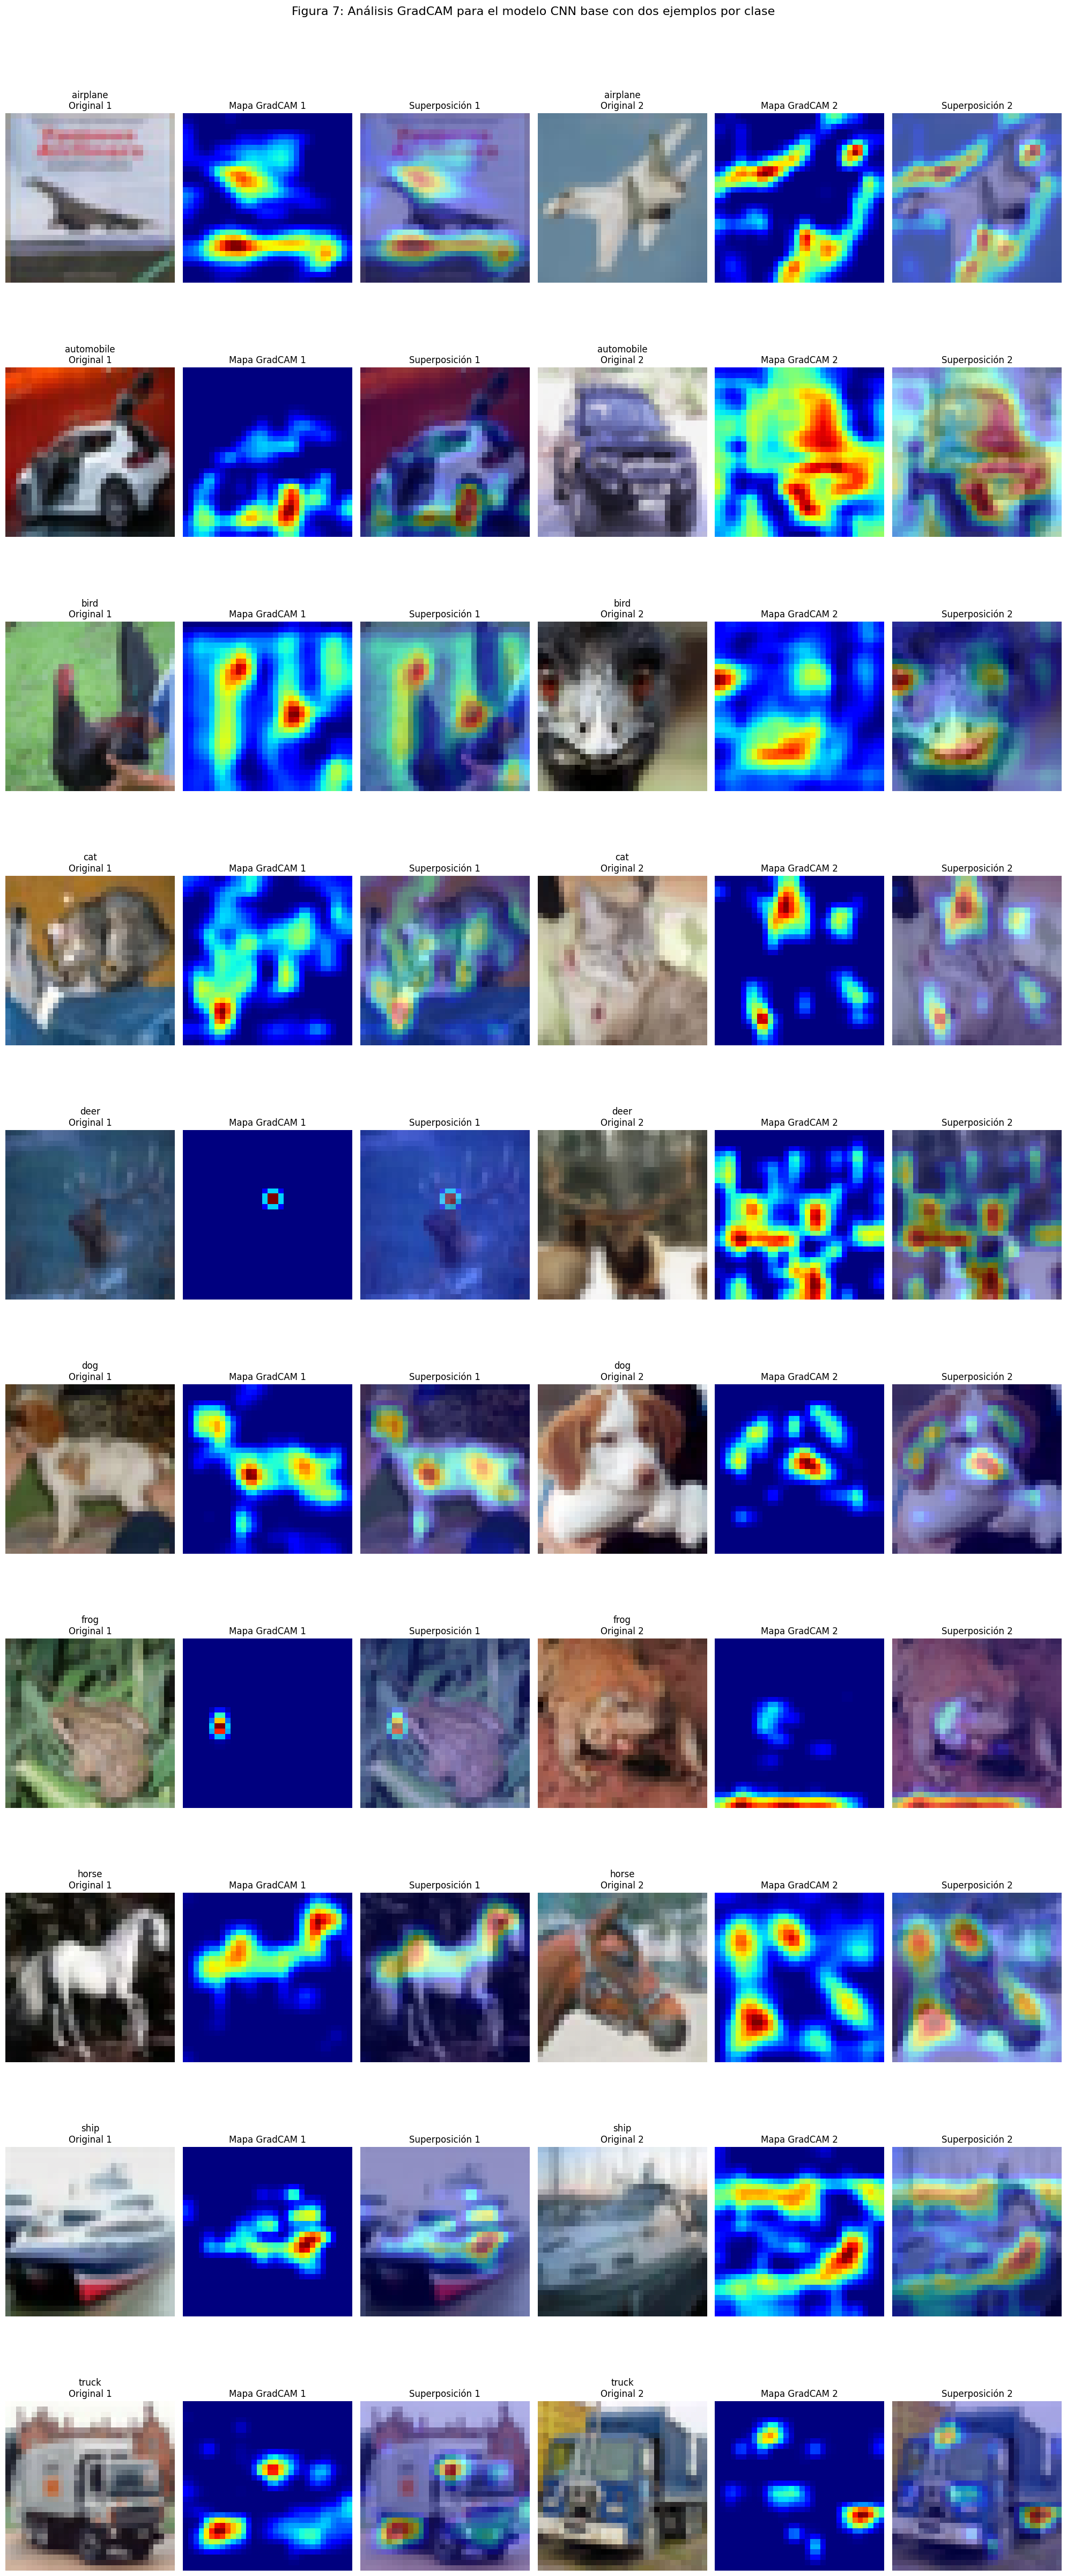

In [48]:
# Definimos los nombres de las clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# La capa objetivo es la última capa convolucional del modelo CNN base
# Siguiendo la recomendación específica del profesor
target_layer = model_cnn_base[1].conv2

# Aplicamos GradCAM al modelo CNN base
gradcam_samples = visualize_gradcam_for_cnn_base(
    model_cnn_base,
    target_layer,
    test_loader,
    device,
    class_names
)

**Aviones**: las activaciones no se concentran en el cuerpo del avión sino en las áreas circundantes. El contraste entre el avión y el fondo parece ser la característica principal que utiliza el modelo para la clasificación, no la estructura del avión en sí.

**Automóviles**: el primer ejemplo muestra activación en las ruedas y parte inferior, mientras el segundo resalta el centro del vehículo con un patrón en forma de cruz. El modelo detecta diferentes partes estructurales según el ejemplar.

**Aves**: en el primer caso detecta parte del cuerpo, mientras en el segundo, que muestra un primer plano de la cara de un ave, las activaciones se concentran en las regiones correspondientes a ojos y pico, elementos definitorios para la identificación.

**Gatos**: las activaciones varían bastante. El primer ejemplo muestra puntos dispersos, y es dificil decir donde se localiza la activación, mientras que el segundo tiene la activación más localizada, quizá en las orejas y algunas partes del cuerpo. El modelo parece tener dificultades para identificar características consistentes en esta clase.

**Ciervos**: la respuesta no es nada consistente. El primer ejemplar apenas genera activaciones, salvo un punto aislado en la cornamenta, así que parece tener dificultades de reconocimiento. El segundo muestra activación en la algunas regiones de la cabeza y el cuerpo, posiblemente detectando astas o orejas.

**Perros**: el primer ejemplo identifica claramente varias zonas del cuerpo, incluyendo cabeza y lo que parecen ser las patas delanteras y traseras. El segundo muestra activaciones más concentradas en regiones faciales como orejas y hocico. Esto parece indicar que el modelo reconoce tanto la estructura corporal completa como características faciales específicas.

**Ranas**: la primera imagen muestra activación en un punto muy específico del cuerpo, ignorando el resto. En el segundo caso, la activación principal está en una banda horizontal inferior que no corresponde al animal. El modelo parece tener problemas identificando ranas en ciertas posiciones o entornos.

**Caballos**: El primer ejemplo muestra activaciones que siguen parcialmente el contorno del lomo. En el segundo caso, que muestra la cabeza de un caballo, las activaciones se concentran en las orejas, el contorno del cuello y parte del hocico, demostrando capacidad para reconocer características parciales de la cabeza del animal.

**Barcos**: Las activaciones resaltan elementos estructurales en ambos casos. En el primer ejemplo se centran en la parte superior del casco y en el segundo en la estructura inferior y el contraste con el fondo (cielo). El modelo parece identificar componentes específicos de las embarcaciones.

**Camiones**: aquí las activaciones en ambos ejemplos destacan puntos específicos de la estructura. En el primer camión, se observan dos focos intensos de activación en las esquina superior de la cabina y la rueda trasera del vehículo y una tercera, menos instensa, en la parte delantera. El segundo ejemplo muestra activaciones en puntos dispersos, pero las más intensas parecen corresponder a las mismas zonas, es decir, rueda y parte de la cabina.



### 3.2 Interpretación de los resultados<a name="interpretacion_explicabilidad"></a>

El análisis que hemos hecho de los mapas GradCAM lo podemos resumir de la siguiente manera:

1. El modelo presenta capacidades variables de detección: funciona mejor con algunas clases (caballos, automóviles) que con otras (ranas, ciervos).

2. Las activaciones pueden basarse tanto en la estructura global como en características locales específicas, dependiendo de la clase y la presentación del elemento que quiere catalogar.

3. La variación de activaciones entre ejemplos distintos de la misma clase indica que el modelo utiliza diferentes conjuntos de características según la pose y el ángulo en el que se ha capturado el objeto.

4. La capacidad para detectar características faciales en primeros planos (caballos, perros, aves) contrasta con la menor precisión en la identificación de cuerpos completos en algunas categorías.

5. El modelo a veces presta atención a elementos del contexto o a contrastes entre objeto y fondo, más que al objeto mismo, como se ve claramente en la clase correspondiente a los aviones.

El análisis mediante GradCAM proporciona indicios sobre los aciertos y las limitaciones del modelo CNN base, y explica parcialmente su rendimiento del 85.50% en el conjunto de prueba. Los resultados sugieren que mejorar la capacidad del modelo para detectar características consistentes, especialmente en clases problemáticas como ranas y ciervos, podría incrementar su rendimiento general.

### 3.3 Conclusiones y dudas del análisis de explicabilidad<a name="conclusiones_explicabilidad"></a>

Los mapas de activación GradCAM permiten descifrar los mecanismos de clasificación del modelo CNN base. Parece que el modelo no siempre se centra en características puntuales, como ojos o ruedas, sino que en ocasiones se _fija_ en características más globales, activando regiones amplias que corresponden a la estructura general de los objetos. Una posible causa aunque quizá aventurada es pensar en esto como una estrategia que compensa la baja resolución de las imágenes en CIFAR-10 (32×32 píxeles), que podría dificultar la capacidad del modelo para identificar de detalles finos.

Las características que más parecen influir en la clasificación incluyen:
- La distribución espacial de elementos, sobre todo en los vehículos.
- Los patrones de contraste entre el objeto y su fondo, que se observa claramente en la clase aviones.
- Rasgos estructurales generales que varían según la categoría.

Este comportamiento, por lo menos en este problema, difiere de la percepción humana; nosotros tendemos a fijarnos en elementos específicos como rostros en los animales o componentes funcionales en los vehículos (ruedas, alas, velas, cuernos). El modelo, en cambio, parece detectar configuraciones espaciales bastante más abstractas.

Algunas dudas sobre las implicaciones de estos resultados:
1. La tendencia del modelo a activar regiones amplias, en ciertos ejemplos, en lugar de puntos específicos, puede ser una ventaja de cara a las variaciones pequeñas o a las oclusiones parciales.
2. Pero, aunque puede ser una ventaja, también puede limitar la capacidad de discernir entre clases que tengan características generales parecidas.
3. La variabilidad en las estrategias de clasificación entre clases hace pensar que no existe un mecanismo o un patrón de clasificación del todo específico o reconocible.

Podríamos decir que la capacidad del modelo para generalizar a partir de características generales explica en parte su rendimiento del 85.50% en el conjunto de prueba. Posiblemente si incorporamos mecanismos de atención (filtros), situados estratégicamente, que permitan un aproximación más selectiva hacia características más diferenciadoras podría incrementar la precisión en algunas clases que ahora parecen no funcionar mucho como ranas y ciervos.

In [50]:
download_saved_models_folder()

Comprimiendo la carpeta 'saved_models'...
Archivo zip creado: saved_models.zip (156.68 MB)
Iniciando descarga...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Si la descarga no comienza automáticamente, verifica:
1. Que no tengas bloqueadores de ventanas emergentes activados
2. Que tu navegador permita descargas desde Colab
